<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week15_RoBERTa_baseline_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week15: This notebook uses Pre-Trained word matrix-> SMOTE -> undersample by EDA -> append to word vectors. -> using Word2Vec. After that I apply SMOTE to balance out. 
Added task: Grid Search for best parameter in SVM.

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### set up

In [ ]:
!pip3 install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.0 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

def get_balanced_accuracy(model):
  test_y = test.map(map_func_only_y)
  y_category=np.zeros((TEST_SIZE, ))
  counter=0
  for label_tensor in test_y.take(len(test_y)):
    y_test = np.argmax(label_tensor, axis=1)
    for label in y_test:
      y_category[counter]=label
      counter+=1

  X_test, y_test = test.map(map_func_only_X), y_category
  y_predict_test = np.asarray(model.predict(X_test))
  y_predict_test = np.argmax(y_predict_test, axis=1)
  print(classification_report(y_test, y_predict_test) )
  print(balanced_accuracy_score(y_test, y_predict_test))

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
df_genre_by_lang = pd.read_csv(DIR + 'df_genre_by_lang_full.csv')
df_genre_by_lang

Unnamed: 0                id             genres lang  \
0               0  0009fFIM1eYThaPg                pop   en   
1               1  00P2bHdWFkghmDqz               soul   en   
2               2  00b6fV3nx5z2b8Ls                pop   en   
3               3  013QDoTqbexEwkHr                pop   en   
4               4  01EKNot8qVgZpKM7               rock   en   
...           ...               ...                ...  ...   
13535       13535  zzT504Z94j1IAuc3         indie rock   en   
13536       13536  zzgS4ZqyswamEWNj                pop   en   
13537       13537  zzx8CWdM7qkxKQpC         indie rock   en   
13538       13538  zzz0n04uuTUA7fNh                pop   en   
13539       13539  zzzj3LYaZtYtbzSr  singer-songwriter   en   

                                                   lyric  number_of_line  
0      a sunny day so I got nowhere to hide Not a clo...              91  
1      Tell me a tale that always was Sing me a song ...              36  
2      A buh A buh You went to school to learn girl T...              74  
3      like a conversation where stops to breathe Is ...              20  
4      Say the words I cannot say Say them on another...              31  
...                                                  ...             ...  
13535  think what afraid of come in you know been mad...              18  
13536  Oh yeah yeah Last night I took a walk in the s...              75  
13537  Innocence it come easy in a sense it never wil...              34  
13538  Girl you know how I feel I really Since you be...              65  
13539  wwI oh must go on standing You break that whic...              64  

[13540 rows x 6 columns]

In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

texts             labels
0      [a, sunny, day, so, I, got, nowhere, to, hide,...                pop
1      [Tell, me, a, tale, that, always, was, Sing, m...               soul
2      [A, buh, A, buh, You, went, to, school, to, le...                pop
3      [like, a, conversation, where, stops, to, brea...                pop
4      [Say, the, words, I, cannot, say, Say, them, o...               rock
...                                                  ...                ...
13535  [think, what, afraid, of, come, in, you, know,...         indie rock
13536  [Oh, yeah, yeah, Last, night, I, took, a, walk...                pop
13537  [Innocence, it, come, easy, in, a, sense, it, ...         indie rock
13538  [Girl, you, know, how, I, feel, I, really, Sin...                pop
13539  [wwI, oh, must, go, on, standing, You, break, ...  singer-songwriter

[13540 rows x 2 columns]

In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
len(splits)

5

In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Apply Data Augmentation Preprocess

In [ ]:
int(1/4)+1

1

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1#each technique at least increment one new song
	#print("new songs per song is:", num_new_per_technique)
	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

### Augment equal ratio each song, try doube.

In [ ]:
genre_mapping = {}
for code,genre in enumerate(label_mapping):
  genre_mapping[genre] = code
  print(code, genre)

0 electronic
1 folk
2 indie pop
3 indie rock
4 pop
5 punk
6 rap
7 rock
8 singer-songwriter
9 soul


In [ ]:
genre_mapping

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [ ]:
df_y_train = pd.DataFrame(split0['y_train'])#, index = split0['y_train'].index, columns=["genres"])

counter = Counter(df_y_train['labels'])
counter

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [ ]:
MIN_COUNT = min(counter.values())
MIN_COUNT

306

In [ ]:
SCALER = 4

In [ ]:
#We already know that:
#final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
genre_needs_per_song = {}
for genre, count in counter.items():
  #each song is double
  genre_needs_per_song[genre] = SCALER-1 # try this to increment by 4
  #if genre != 4:
  #  genre_needs_per_song[genre] = int(round((genre_dict[4] - count)/count, 0))
genre_needs_per_song

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3}

Be careful, we cannot run this function twice!!

WE ONLY AUGMENT TRAINING DATA

In [ ]:
ORIGINAL_SIZE = split0['X_train'].tail(1).index.item()
ORIGINAL_SIZE

13539

In [ ]:
X_train_eda = pd.Series(data = [])
y_train_eda = pd.Series(data = [])
augmented_count_by_genre ={}

for genre in range(10):
  augmented_count_by_genre[genre]=MIN_COUNT*SCALER
augmented_count_by_genre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


{0: 1224,
 1: 1224,
 2: 1224,
 3: 1224,
 4: 1224,
 5: 1224,
 6: 1224,
 7: 1224,
 8: 1224,
 9: 1224}

In [ ]:
for idx, token_list in split0['X_train'].loc[0:ORIGINAL_SIZE].items():
  genre_code = split0['y_train'].loc[idx]
  #genre = genre_mapping[genre_code]
  #if genre_code != 4:
  if augmented_count_by_genre[genre_code] <= 0 or Counter(y_train_eda)[genre_code] >= MIN_COUNT*SCALER:
    continue

  else:
    needs = genre_needs_per_song[genre_code]
    original_df_row = df_genre_by_lang.loc[idx]
    new_songs= eda(original_df_row['lyric'], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=needs)

    augmented_count_by_genre[genre_code]-=len(new_songs)

    for new_song in new_songs:
      new_song_tokens = new_song.split(' ')
      X_train_eda = X_train_eda.append( pd.Series([new_song_tokens]) , ignore_index=True)
      y_train_eda = y_train_eda.append( pd.Series( [genre_code] ) , ignore_index=True)
    
    #split0['X_train'] = split0['X_train'].append( pd.Series([new_song_tokens]) , ignore_index=True)
    #split0['y_train'] = split0['y_train'].append( pd.Series( [genre_code] ) , ignore_index=True)
      

In [ ]:
y_train_eda

0        4
1        4
2        4
3        4
4        9
        ..
12235    5
12236    5
12237    5
12238    5
12239    5
Length: 12240, dtype: int8

In [ ]:
Counter(y_train_eda)

Counter({0: 1224,
         1: 1224,
         2: 1224,
         3: 1224,
         4: 1224,
         5: 1224,
         6: 1224,
         7: 1224,
         8: 1224,
         9: 1224})

In [ ]:
Counter(split0['y_train'])

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [ ]:
Counter(split0['y_test'])

Counter({0: 190,
         1: 173,
         2: 135,
         3: 216,
         4: 1036,
         5: 76,
         6: 195,
         7: 290,
         8: 139,
         9: 258})

In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

### Visualize Glove embedded lyric documents

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100]# , 200, 300, 400

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)

  #2.create word embedding and vector representation for each song
  gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

  #2-1.I want to add vocab from Gloeve
  X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
  #print(X_embeddings_temp)
  
  #3.SMOTE on train
  X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])
  
  #3-1. undersample by eda
  X_embeddings_minor = gensim_word2vec_tr_temp.transform( X_train_eda )

=======SIZE:  100 ========
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


Visualize EDA data via Glove's embedded weight matrix

In [ ]:
del(df_word_vector2)

In [ ]:
print(X_embeddings_minor.shape, y_train_eda.shape)

(12240, 100) (12240,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector2 = pd.DataFrame(X_embeddings_minor)

In [ ]:
type(y_train_eda)

pandas.core.series.Series

In [ ]:
df_word_vector2['y'] = -1
for i, (_, genre_code) in enumerate(y_train_eda.items()):
  df_word_vector2.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector2.shape

(12240, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca2 = PCA(n_components=3)
pca_result2 = pca2.fit_transform(df_word_vector2[feature_cols].values)

df_word_vector2['pca-one'] = pca_result2[:,0]
df_word_vector2['pca-two'] = pca_result2[:,1] 
df_word_vector2['pca-three'] = pca_result2[:,2]

print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))

Explained variation per principal component: [0.09708969 0.05725645 0.04293769]


In [ ]:
number_of_y = len(set(df_word_vector2["y"]))
number_of_y

10

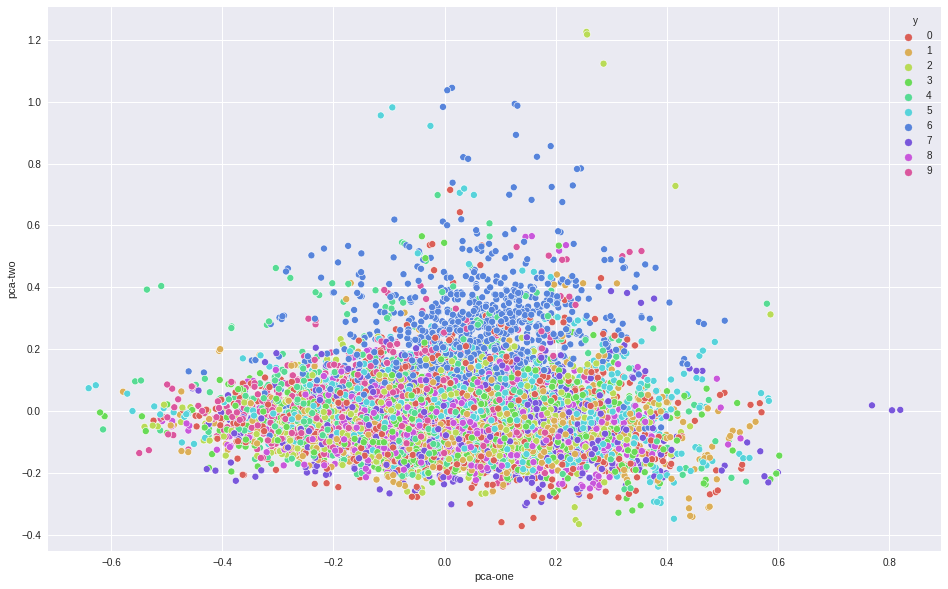

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector2.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector2.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize original lyrics document (X_embeddings_temp) via Glove weight matrix

In [ ]:
del(df_word_vector3)

In [ ]:
print(X_embeddings_temp.shape, split0['y_train'].shape)

(10832, 100) (10832,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector3 = pd.DataFrame(X_embeddings_temp)

In [ ]:
df_word_vector3.shape

(10832, 100)

In [ ]:
type(split0['y_train'])

pandas.core.series.Series

In [ ]:
df_word_vector3['y'] = -1
print(df_word_vector3.shape)

(10832, 101)


In [ ]:
for i, (_, genre_code) in enumerate(split0['y_train'].items()):
  #print(i, genre_code)
  df_word_vector3.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector3.shape

(10832, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca3 = PCA(n_components=3)
pca_result3 = pca3.fit_transform(df_word_vector3[feature_cols].values)

df_word_vector3['pca-one'] = pca_result3[:,0]
df_word_vector3['pca-two'] = pca_result3[:,1] 
df_word_vector3['pca-three'] = pca_result3[:,2]

print('Explained variation per principal component: {}'.format(pca3.explained_variance_ratio_))

Explained variation per principal component: [0.08235912 0.0571936  0.04286555]


In [ ]:
number_of_y = len(set(df_word_vector3["y"]))
number_of_y

10

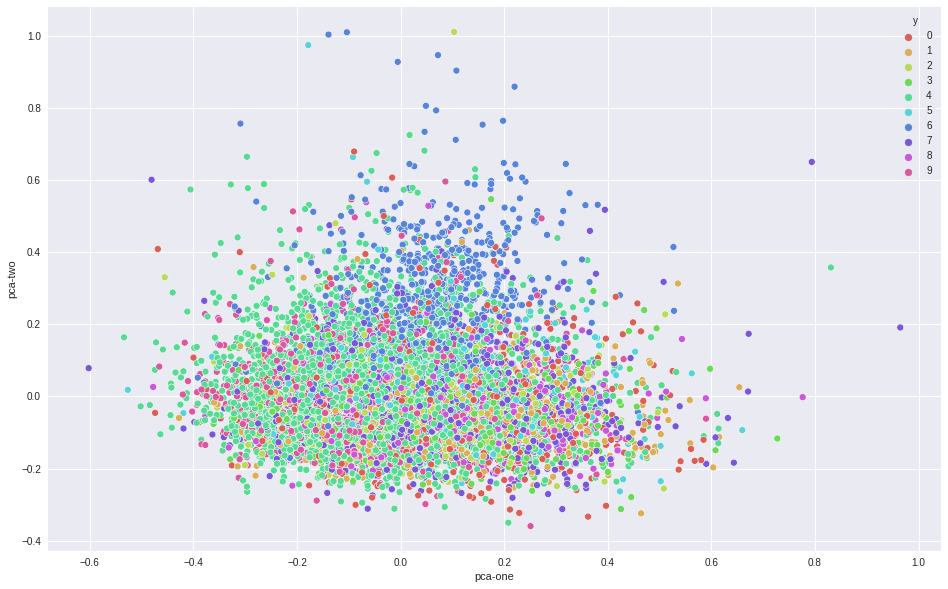

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector3.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector3.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize original data after SMOTE

In [ ]:
print(X_resampled_temp.shape, y_resampled_temp.shape)#X_resampled_temp, y_resampled_temp

(41430, 100) (41430,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector4 = pd.DataFrame(X_resampled_temp)

In [ ]:
df_word_vector4.shape

(41430, 100)

In [ ]:
type(y_resampled_temp)

pandas.core.series.Series

In [ ]:
df_word_vector4['y'] = -1
print(df_word_vector4.shape)

(41430, 101)


In [ ]:
for i, (_, genre_code) in enumerate(y_resampled_temp.items()):
  #print(i, genre_code)
  df_word_vector4.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector4.shape

(41430, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca4 = PCA(n_components=3)
pca_result4 = pca4.fit_transform(df_word_vector4[feature_cols].values)

df_word_vector4['pca-one'] = pca_result4[:,0]
df_word_vector4['pca-two'] = pca_result4[:,1] 
df_word_vector4['pca-three'] = pca_result4[:,2]

print('Explained variation per principal component: {}'.format(pca4.explained_variance_ratio_))

Explained variation per principal component: [0.10478059 0.07526815 0.04039155]


In [ ]:
number_of_y = len(set(df_word_vector4["y"]))
number_of_y

10

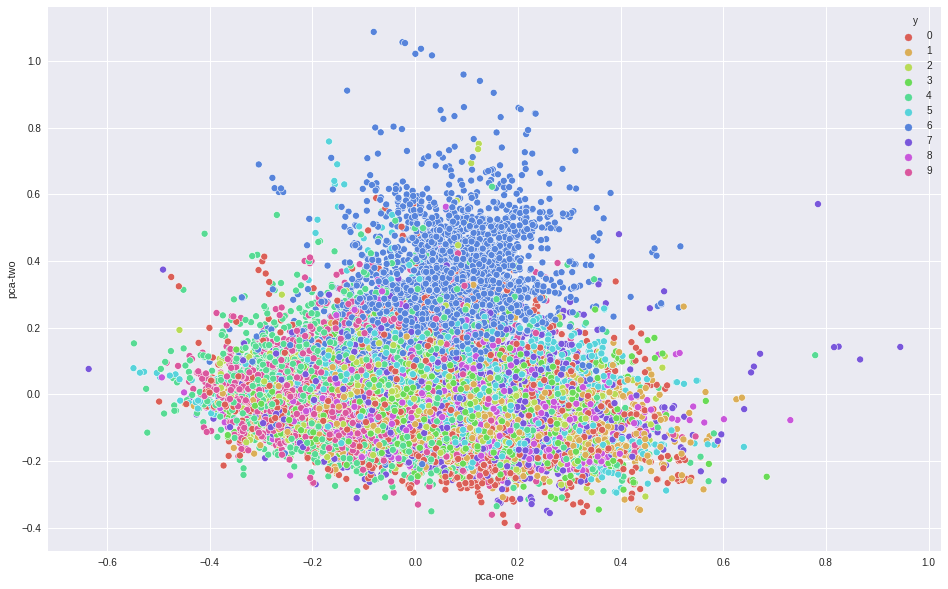

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector4.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector4.loc[rndperm,:],
    legend="full",
    alpha=1
)

### First check Glove without EDA to compare later

In [ ]:
len(splits)

5

In [ ]:
def X_train_test_prepare():
  if type(split0['X_train'][0]) is not list:
    for idx, lyrics in split0['X_train'].items():
      split0['X_train'][idx] = lyrics.split(' ')
  first_index =split0['X_test'].index[0]
  if type(split0['X_test'][first_index]) is not list:
    for idx, lyrics in split0['X_test'].items():
      split0['X_test'][idx] = lyrics.split(' ')

In [ ]:
X_train_test_prepare()

In [ ]:
# List of C values
C_range = np.logspace(-1, 1, 3)
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = np.logspace(-1, 1, 3)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [ 0.1  1.  10. ]
The list of values for gamma are [ 0.1  1.  10. ]


In [ ]:
C_list = C_range.tolist()
C_list

[0.1, 1.0, 10.0]

In [ ]:
gamma_list = gamma_range.tolist()+['scale', 'auto']
gamma_list

[0.1, 1.0, 10.0, 'scale', 'auto']

In [ ]:
kernel_list = ['rbf']#'poly',  'linear'
kernel_list

['rbf']

In [ ]:
SIZE_PARAMETER = [100, 200, 300]
#n_estimators = [100,200,300,400]
McNemar = {}
for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )] = []
McNemar

{(0, 100, 'rbf', 0.1, 0.1): [],
 (0, 100, 'rbf', 0.1, 1.0): [],
 (0, 100, 'rbf', 0.1, 10.0): [],
 (0, 100, 'rbf', 1.0, 0.1): [],
 (0, 100, 'rbf', 1.0, 1.0): [],
 (0, 100, 'rbf', 1.0, 10.0): [],
 (0, 100, 'rbf', 10.0, 0.1): [],
 (0, 100, 'rbf', 10.0, 1.0): [],
 (0, 100, 'rbf', 10.0, 10.0): [],
 (0, 100, 'rbf', 'scale', 0.1): [],
 (0, 100, 'rbf', 'scale', 1.0): [],
 (0, 100, 'rbf', 'scale', 10.0): [],
 (0, 100, 'rbf', 'auto', 0.1): [],
 (0, 100, 'rbf', 'auto', 1.0): [],
 (0, 100, 'rbf', 'auto', 10.0): [],
 (0, 200, 'rbf', 0.1, 0.1): [],
 (0, 200, 'rbf', 0.1, 1.0): [],
 (0, 200, 'rbf', 0.1, 10.0): [],
 (0, 200, 'rbf', 1.0, 0.1): [],
 (0, 200, 'rbf', 1.0, 1.0): [],
 (0, 200, 'rbf', 1.0, 10.0): [],
 (0, 200, 'rbf', 10.0, 0.1): [],
 (0, 200, 'rbf', 10.0, 1.0): [],
 (0, 200, 'rbf', 10.0, 10.0): [],
 (0, 200, 'rbf', 'scale', 0.1): [],
 (0, 200, 'rbf', 'scale', 1.0): [],
 (0, 200, 'rbf', 'scale', 10.0): [],
 (0, 200, 'rbf', 'auto', 0.1): [],
 (0, 200, 'rbf', 'auto', 1.0): [],
 (0, 200, 'rbf', '

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100]#, 200, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.12      0.13       190
           1       0.18      0.38      0.25       173
           2       0.09      0.29      0.14       135
           3       0.20      0.20      0.20       216
           4       0.56      0.08      0.14      1036
           5       0.17      0.41      0.24        76
           6       0.67      0.68      0.68       195
           7       0.08      0.00      0.01       290
           8       0.12      0.05      0.07       139
           9       0.15      0.56      0.24       258

    accuracy                           0.21      2708
   macro avg       0.24      0.28      0.21      2708
weighted avg       0.34      0.21      0.18      2708

0.2767079232579879
==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.22      0.19       190
           1       0.19      0.34      0.25       173
           2       0.07      0.14      0.09       135
           3       0.18      0.13      0.15       216
           4       0.60      0.19      0.29      1036
           5       0.12      0.39      0.19        76
           6       0.67      0.75      0.71       195
           7       0.19      0.07      0.10       290
           8       0.13      0.17      0.15       139
           9       0.18      0.47      0.26       258

    accuracy                           0.25      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.37      0.25      0.26      2708

0.28721438515678555
==SIZE:  100 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.19      0.15       190
           1       0.21      0.33      0.26       173
           2       0.08      0.14      0.10       135
           3       0.16      0.14      0.15       216
           4       0.56      0.24      0.34      1036
           5       0.12      0.33      0.18        76
           6       0.68      0.78      0.73       195
           7       0.17      0.09      0.12       290
           8       0.12      0.14      0.13       139
           9       0.20      0.42      0.28       258

    accuracy                           0.27      2708
   macro avg       0.24      0.28      0.24      2708
weighted avg       0.35      0.27      0.28      2708

0.2798122062863354
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.19      0.17       190
           1       0.22      0.38      0.28       173
           2       0.08      0.14      0.10       135
           3       0.21      0.13      0.16       216
           4       0.53      0.24      0.33      1036
           5       0.13      0.38      0.20        76
           6       0.68      0.74      0.71       195
           7       0.20      0.08      0.11       290
           8       0.13      0.16      0.15       139
           9       0.21      0.47      0.29       258

    accuracy                           0.27      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.35      0.27      0.28      2708

0.29252885138013374
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.20      0.17       190
           1       0.23      0.36      0.28       173
           2       0.07      0.10      0.08       135
           3       0.16      0.17      0.16       216
           4       0.55      0.30      0.39      1036
           5       0.16      0.32      0.21        76
           6       0.70      0.77      0.73       195
           7       0.16      0.09      0.11       290
           8       0.16      0.19      0.18       139
           9       0.22      0.43      0.29       258

    accuracy                           0.29      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.35      0.29      0.30      2708

0.2931295204436152
==SIZE:  100 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.14      0.13       190
           1       0.20      0.28      0.24       173
           2       0.10      0.12      0.11       135
           3       0.15      0.18      0.17       216
           4       0.53      0.42      0.47      1036
           5       0.21      0.20      0.20        76
           6       0.76      0.76      0.76       195
           7       0.15      0.13      0.14       290
           8       0.15      0.14      0.14       139
           9       0.21      0.30      0.25       258

    accuracy                           0.32      2708
   macro avg       0.26      0.27      0.26      2708
weighted avg       0.35      0.32      0.33      2708

0.2669176219067199
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.09      0.09      0.09       190
           1       0.24      0.16      0.19       173
           2       0.12      0.07      0.09       135
           3       0.22      0.12      0.15       216
           4       0.42      0.63      0.51      1036
           5       0.17      0.14      0.16        76
           6       0.80      0.63      0.70       195
           7       0.15      0.07      0.09       290
           8       0.23      0.08      0.12       139
           9       0.21      0.21      0.21       258

    accuracy                           0.35      2708
   macro avg       0.27      0.22      0.23      2708
weighted avg       0.32      0.35      0.32      2708

0.21984781861161853
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.04      0.06       190
           1       0.28      0.21      0.24       173
           2       0.17      0.06      0.09       135
           3       0.21      0.12      0.16       216
           4       0.46      0.82      0.59      1036
           5       0.32      0.09      0.14        76
           6       0.82      0.68      0.74       195
           7       0.20      0.11      0.14       290
           8       0.32      0.09      0.14       139
           9       0.26      0.14      0.18       258

    accuracy                           0.42      2708
   macro avg       0.32      0.24      0.25      2708
weighted avg       0.36      0.42      0.36      2708

0.2350069902348523
==SIZE:  100 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.03      0.05       190
           1       0.28      0.18      0.22       173
           2       0.15      0.04      0.06       135
           3       0.24      0.15      0.18       216
           4       0.45      0.84      0.59      1036
           5       0.38      0.07      0.11        76
           6       0.85      0.68      0.75       195
           7       0.18      0.09      0.12       290
           8       0.34      0.07      0.12       139
           9       0.30      0.12      0.17       258

    accuracy                           0.42      2708
   macro avg       0.33      0.23      0.24      2708
weighted avg       0.36      0.42      0.35      2708

0.22597607384607898
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.18      0.17       190
           1       0.23      0.40      0.29       173
           2       0.07      0.16      0.10       135
           3       0.18      0.12      0.14       216
           4       0.56      0.19      0.28      1036
           5       0.14      0.43      0.22        76
           6       0.71      0.73      0.72       195
           7       0.20      0.06      0.09       290
           8       0.09      0.10      0.10       139
           9       0.18      0.50      0.26       258

    accuracy                           0.25      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.36      0.25      0.25      2708

0.28829931072961934
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.27      0.21       190
           1       0.21      0.32      0.25       173
           2       0.07      0.12      0.09       135
           3       0.17      0.14      0.15       216
           4       0.56      0.26      0.35      1036
           5       0.14      0.36      0.20        76
           6       0.71      0.78      0.75       195
           7       0.19      0.10      0.13       290
           8       0.14      0.18      0.16       139
           9       0.20      0.41      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.36      0.28      0.29      2708

0.29401897003903815
==SIZE:  100 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.23      0.18       190
           1       0.23      0.33      0.27       173
           2       0.06      0.10      0.07       135
           3       0.15      0.14      0.15       216
           4       0.57      0.36      0.44      1036
           5       0.12      0.17      0.14        76
           6       0.71      0.76      0.74       195
           7       0.17      0.14      0.15       290
           8       0.14      0.14      0.14       139
           9       0.22      0.36      0.27       258

    accuracy                           0.31      2708
   macro avg       0.25      0.27      0.26      2708
weighted avg       0.36      0.31      0.32      2708

0.2728258966816652
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.21      0.22      0.22       173
           2       0.07      0.19      0.10       135
           3       0.14      0.38      0.20       216
           4       0.40      0.00      0.00      1036
           5       0.43      0.08      0.13        76
           6       0.83      0.51      0.63       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.13      0.74      0.22       258

    accuracy                           0.16      2708
   macro avg       0.22      0.21      0.15      2708
weighted avg       0.27      0.16      0.11      2708

0.2117722794059632
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.11      0.13       190
           1       0.18      0.29      0.23       173
           2       0.09      0.29      0.14       135
           3       0.19      0.18      0.18       216
           4       0.59      0.10      0.17      1036
           5       0.16      0.41      0.23        76
           6       0.67      0.68      0.68       195
           7       0.21      0.01      0.03       290
           8       0.13      0.12      0.12       139
           9       0.15      0.56      0.24       258

    accuracy                           0.22      2708
   macro avg       0.25      0.28      0.21      2708
weighted avg       0.36      0.22      0.20      2708

0.2753106370340991
==SIZE:  100 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.19      0.16       190
           1       0.18      0.34      0.24       173
           2       0.09      0.18      0.12       135
           3       0.18      0.15      0.16       216
           4       0.62      0.20      0.30      1036
           5       0.14      0.42      0.22        76
           6       0.66      0.75      0.71       195
           7       0.18      0.08      0.11       290
           8       0.15      0.16      0.15       139
           9       0.20      0.49      0.28       258

    accuracy                           0.26      2708
   macro avg       0.26      0.30      0.24      2708
weighted avg       0.38      0.26      0.26      2708

0.2959047094003801
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.00      0.00      0.00       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.01      0.10      0.01      2708
weighted avg       0.01      0.08      0.01      2708

0.1
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       1.00      0.01      0.01       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.11      0.10      0.02      2708
weighted avg       0.07      0.08      0.01      2708

0.10057803468208093
==SIZE:  100 ==kernel: poly ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Update

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.00      0.00      0.00       173
           2       0.00      0.00      0.00       135
           3       0.08      1.00      0.15       216
           4       0.00      0.00      0.00      1036
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       195
           7       0.00      0.00      0.00       290
           8       0.00      0.00      0.00       139
           9       0.00      0.00      0.00       258

    accuracy                           0.08      2708
   macro avg       0.01      0.10      0.01      2708
weighted avg       0.01      0.08      0.01      2708

0.1
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       190
           1       0.18      0.20      0.19       173
           2       0.10      0.11      0.11       135
           3       0.17      0.17      0.17       216
           4       0.52      0.57      0.54      1036
           5       0.17      0.14      0.15        76
           6       0.70      0.76      0.73       195
           7       0.13      0.11      0.12       290
           8       0.18      0.13      0.15       139
           9       0.24      0.21      0.23       258

    accuracy                           0.35      2708
   macro avg       0.25      0.25      0.25      2708
weighted avg       0.34      0.35      0.34      2708

0.24828995397215975
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.12      0.11       190
           1       0.20      0.24      0.21       173
           2       0.09      0.10      0.09       135
           3       0.15      0.15      0.15       216
           4       0.52      0.56      0.54      1036
           5       0.17      0.12      0.14        76
           6       0.72      0.78      0.75       195
           7       0.14      0.12      0.13       290
           8       0.16      0.11      0.13       139
           9       0.21      0.19      0.20       258

    accuracy                           0.35      2708
   macro avg       0.25      0.25      0.25      2708
weighted avg       0.34      0.35      0.34      2708

0.24760912424047626
==SIZE:  100 ==kernel: poly ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.11      0.12      0.12       190
           1       0.19      0.24      0.21       173
           2       0.10      0.11      0.10       135
           3       0.13      0.13      0.13       216
           4       0.52      0.55      0.53      1036
           5       0.13      0.11      0.12        76
           6       0.70      0.73      0.72       195
           7       0.15      0.12      0.13       290
           8       0.14      0.11      0.12       139
           9       0.24      0.21      0.22       258

    accuracy                           0.34      2708
   macro avg       0.24      0.24      0.24      2708
weighted avg       0.33      0.34      0.34      2708

0.24152627854624753
==SIZE:  100 ==kernel: poly ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [200]#, 200, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.18      0.11      0.13       190
           1       0.19      0.39      0.25       173
           2       0.10      0.33      0.15       135
           3       0.17      0.14      0.16       216
           4       0.56      0.10      0.17      1036
           5       0.17      0.39      0.23        76
           6       0.71      0.69      0.70       195
           7       0.20      0.01      0.02       290
           8       0.15      0.08      0.10       139
           9       0.15      0.57      0.24       258

    accuracy                           0.22      2708
   macro avg       0.26      0.28      0.22      2708
weighted avg       0.36      0.22      0.20      2708

0.28018987123386097
==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.16      0.23      0.19       190
           1       0.19      0.32      0.24       173
           2       0.12      0.19      0.15       135
           3       0.17      0.14      0.15       216
           4       0.60      0.25      0.35      1036
           5       0.12      0.34      0.18        76
           6       0.71      0.75      0.73       195
           7       0.19      0.09      0.13       290
           8       0.15      0.19      0.17       139
           9       0.20      0.44      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.37      0.28      0.29      2708

0.295806994063765
==SIZE:  200 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.22      0.16       190
           1       0.22      0.31      0.25       173
           2       0.09      0.18      0.12       135
           3       0.16      0.17      0.16       216
           4       0.59      0.31      0.41      1036
           5       0.10      0.22      0.14        76
           6       0.72      0.78      0.75       195
           7       0.17      0.11      0.13       290
           8       0.15      0.15      0.15       139
           9       0.22      0.36      0.27       258

    accuracy                           0.29      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.37      0.29      0.31      2708

0.2799552862984779
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       190
           1       0.23      0.34      0.27       173
           2       0.11      0.16      0.13       135
           3       0.18      0.13      0.15       216
           4       0.49      0.30      0.38      1036
           5       0.13      0.34      0.19        76
           6       0.71      0.74      0.73       195
           7       0.18      0.08      0.11       290
           8       0.14      0.15      0.15       139
           9       0.20      0.42      0.27       258

    accuracy                           0.29      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.33      0.29      0.29      2708

0.28463097386176245
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.20      0.27      0.23       173
           2       0.10      0.17      0.12       135
           3       0.17      0.16      0.17       216
           4       0.55      0.37      0.45      1036
           5       0.14      0.20      0.16        76
           6       0.75      0.78      0.76       195
           7       0.15      0.10      0.12       290
           8       0.19      0.19      0.19       139
           9       0.21      0.33      0.26       258

    accuracy                           0.31      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.36      0.31      0.32      2708

0.2754360051379065
==SIZE:  200 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       190
           1       0.20      0.25      0.22       173
           2       0.13      0.13      0.13       135
           3       0.20      0.19      0.20       216
           4       0.52      0.54      0.53      1036
           5       0.20      0.14      0.17        76
           6       0.76      0.75      0.75       195
           7       0.15      0.12      0.13       290
           8       0.21      0.14      0.17       139
           9       0.25      0.29      0.27       258

    accuracy                           0.36      2708
   macro avg       0.27      0.27      0.27      2708
weighted avg       0.35      0.36      0.36      2708

0.26929738550098475
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.10      0.09      0.09       190
           1       0.29      0.09      0.14       173
           2       0.24      0.04      0.07       135
           3       0.22      0.07      0.11       216
           4       0.41      0.77      0.54      1036
           5       0.13      0.03      0.04        76
           6       0.87      0.52      0.65       195
           7       0.13      0.04      0.07       290
           8       0.29      0.04      0.07       139
           9       0.23      0.17      0.20       258

    accuracy                           0.38      2708
   macro avg       0.29      0.19      0.20      2708
weighted avg       0.33      0.38      0.31      2708

0.18740467945449515
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.16      0.03      0.05       190
           1       0.31      0.16      0.21       173
           2       0.29      0.04      0.07       135
           3       0.21      0.09      0.12       216
           4       0.44      0.89      0.59      1036
           5       0.40      0.03      0.05        76
           6       0.85      0.64      0.73       195
           7       0.16      0.07      0.09       290
           8       0.38      0.07      0.12       139
           9       0.32      0.09      0.14       258

    accuracy                           0.43      2708
   macro avg       0.35      0.21      0.22      2708
weighted avg       0.37      0.43      0.34      2708

0.20871319941774763
==SIZE:  200 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.02      0.04       190
           1       0.34      0.18      0.23       173
           2       0.28      0.04      0.07       135
           3       0.26      0.10      0.14       216
           4       0.44      0.90      0.59      1036
           5       0.12      0.01      0.02        76
           6       0.86      0.62      0.72       195
           7       0.14      0.06      0.08       290
           8       0.33      0.04      0.08       139
           9       0.40      0.09      0.14       258

    accuracy                           0.43      2708
   macro avg       0.33      0.21      0.21      2708
weighted avg       0.37      0.43      0.34      2708

0.20535775309901833
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.18      0.17       190
           1       0.21      0.36      0.27       173
           2       0.09      0.16      0.11       135
           3       0.23      0.17      0.19       216
           4       0.51      0.22      0.31      1036
           5       0.13      0.38      0.19        76
           6       0.72      0.74      0.73       195
           7       0.25      0.07      0.11       290
           8       0.17      0.17      0.17       139
           9       0.18      0.48      0.26       258

    accuracy                           0.27      2708
   macro avg       0.26      0.29      0.25      2708
weighted avg       0.35      0.27      0.27      2708

0.2931806189749512
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.24      0.18       190
           1       0.20      0.29      0.24       173
           2       0.07      0.13      0.09       135
           3       0.20      0.19      0.19       216
           4       0.57      0.31      0.40      1036
           5       0.12      0.25      0.17        76
           6       0.72      0.77      0.74       195
           7       0.20      0.13      0.16       290
           8       0.15      0.17      0.16       139
           9       0.23      0.40      0.29       258

    accuracy                           0.30      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.37      0.30      0.31      2708

0.2855002079462511
==SIZE:  200 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.18      0.16       190
           1       0.19      0.25      0.22       173
           2       0.10      0.16      0.12       135
           3       0.17      0.16      0.17       216
           4       0.55      0.44      0.49      1036
           5       0.16      0.20      0.17        76
           6       0.73      0.74      0.74       195
           7       0.18      0.13      0.15       290
           8       0.14      0.12      0.13       139
           9       0.24      0.33      0.28       258

    accuracy                           0.33      2708
   macro avg       0.26      0.27      0.26      2708
weighted avg       0.36      0.33      0.34      2708

0.2715218734367637
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.19      0.27      0.22       173
           2       0.06      0.16      0.08       135
           3       0.13      0.35      0.19       216
           4       0.25      0.00      0.00      1036
           5       0.62      0.07      0.12        76
           6       0.92      0.12      0.21       195
           7       0.00      0.00      0.00       290
           8       0.29      0.05      0.09       139
           9       0.13      0.73      0.22       258

    accuracy                           0.14      2708
   macro avg       0.26      0.17      0.11      2708
weighted avg       0.23      0.14      0.08      2708

0.1732419056906034
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.04      0.06       190
           1       0.21      0.31      0.25       173
           2       0.09      0.34      0.14       135
           3       0.16      0.21      0.18       216
           4       0.61      0.06      0.11      1036
           5       0.23      0.32      0.27        76
           6       0.70      0.66      0.68       195
           7       0.00      0.00      0.00       290
           8       0.18      0.09      0.12       139
           9       0.14      0.61      0.23       258

    accuracy                           0.20      2708
   macro avg       0.25      0.26      0.20      2708
weighted avg       0.35      0.20      0.17      2708

0.26438558110596
==SIZE:  200 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       190
           1       0.22      0.38      0.28       173
           2       0.09      0.17      0.12       135
           3       0.19      0.16      0.17       216
           4       0.62      0.20      0.30      1036
           5       0.13      0.41      0.20        76
           6       0.70      0.75      0.72       195
           7       0.19      0.07      0.10       290
           8       0.16      0.19      0.17       139
           9       0.18      0.50      0.27       258

    accuracy                           0.26      2708
   macro avg       0.26      0.30      0.25      2708
weighted avg       0.38      0.26      0.27      2708

0.2980148474948979


In [ ]:
balanced_acc_by_dim

{100: [],
 200: [0.28018987123386097,
  0.295806994063765,
  0.2799552862984779,
  0.28463097386176245,
  0.2754360051379065,
  0.26929738550098475,
  0.18740467945449515,
  0.20871319941774763,
  0.20535775309901833,
  0.2931806189749512,
  0.2855002079462511,
  0.2715218734367637,
  0.1732419056906034,
  0.26438558110596,
  0.2980148474948979],
 300: []}

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [300]#, 100, 300

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in kernel_list:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.06      0.08       190
           1       0.18      0.40      0.25       173
           2       0.10      0.33      0.15       135
           3       0.17      0.15      0.16       216
           4       0.56      0.12      0.20      1036
           5       0.17      0.38      0.24        76
           6       0.71      0.70      0.71       195
           7       0.06      0.00      0.01       290
           8       0.15      0.08      0.10       139
           9       0.15      0.56      0.24       258

    accuracy                           0.22      2708
   macro avg       0.24      0.28      0.21      2708
weighted avg       0.34      0.22      0.21      2708

0.2792249669563469
==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.24      0.40      0.30       173
           2       0.07      0.10      0.08       135
           3       0.18      0.15      0.17       216
           4       0.59      0.28      0.38      1036
           5       0.14      0.36      0.20        76
           6       0.72      0.75      0.74       195
           7       0.22      0.13      0.16       290
           8       0.16      0.18      0.17       139
           9       0.21      0.44      0.28       258

    accuracy                           0.29      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.37      0.29      0.30      2708

0.2973582120226341
==SIZE:  300 ==kernel: rbf ==gamma: 0.1 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       190
           1       0.19      0.28      0.23       173
           2       0.09      0.15      0.11       135
           3       0.17      0.15      0.16       216
           4       0.58      0.35      0.44      1036
           5       0.13      0.25      0.17        76
           6       0.75      0.77      0.76       195
           7       0.17      0.12      0.14       290
           8       0.15      0.19      0.17       139
           9       0.23      0.34      0.28       258

    accuracy                           0.30      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.37      0.30      0.32      2708

0.28048680200367687
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.19      0.16       190
           1       0.23      0.33      0.27       173
           2       0.11      0.13      0.11       135
           3       0.21      0.13      0.16       216
           4       0.50      0.36      0.42      1036
           5       0.14      0.32      0.20        76
           6       0.74      0.74      0.74       195
           7       0.17      0.09      0.12       290
           8       0.16      0.15      0.16       139
           9       0.21      0.39      0.27       258

    accuracy                           0.31      2708
   macro avg       0.26      0.28      0.26      2708
weighted avg       0.34      0.31      0.31      2708

0.28336593957116507
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.12      0.18      0.15       190
           1       0.20      0.27      0.23       173
           2       0.13      0.18      0.15       135
           3       0.21      0.19      0.19       216
           4       0.54      0.42      0.47      1036
           5       0.18      0.25      0.21        76
           6       0.73      0.76      0.75       195
           7       0.15      0.10      0.12       290
           8       0.21      0.19      0.20       139
           9       0.21      0.30      0.25       258

    accuracy                           0.33      2708
   macro avg       0.27      0.29      0.27      2708
weighted avg       0.35      0.33      0.33      2708

0.2850924483486984
==SIZE:  300 ==kernel: rbf ==gamma: 1.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       190
           1       0.24      0.25      0.25       173
           2       0.10      0.10      0.10       135
           3       0.21      0.19      0.20       216
           4       0.51      0.60      0.55      1036
           5       0.22      0.16      0.18        76
           6       0.80      0.73      0.77       195
           7       0.16      0.13      0.14       290
           8       0.20      0.13      0.16       139
           9       0.24      0.22      0.23       258

    accuracy                           0.37      2708
   macro avg       0.28      0.26      0.27      2708
weighted avg       0.36      0.37      0.36      2708

0.26412175856748843
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.06      0.04      0.05       190
           1       0.28      0.05      0.09       173
           2       0.23      0.02      0.04       135
           3       0.21      0.05      0.08       216
           4       0.40      0.82      0.54      1036
           5       0.08      0.01      0.02        76
           6       0.88      0.46      0.61       195
           7       0.10      0.03      0.05       290
           8       0.38      0.04      0.07       139
           9       0.20      0.11      0.14       258

    accuracy                           0.38      2708
   macro avg       0.28      0.16      0.17      2708
weighted avg       0.32      0.38      0.29      2708

0.16373310062555518
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.02      0.04       190
           1       0.35      0.13      0.19       173
           2       0.44      0.03      0.06       135
           3       0.27      0.07      0.12       216
           4       0.43      0.92      0.58      1036
           5       0.50      0.01      0.03        76
           6       0.85      0.59      0.70       195
           7       0.14      0.06      0.08       290
           8       0.46      0.04      0.08       139
           9       0.45      0.08      0.13       258

    accuracy                           0.43      2708
   macro avg       0.41      0.20      0.20      2708
weighted avg       0.40      0.43      0.33      2708

0.19553931357952753
==SIZE:  300 ==kernel: rbf ==gamma: 10.0 ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.02      0.03       190
           1       0.40      0.12      0.19       173
           2       0.29      0.03      0.05       135
           3       0.22      0.07      0.11       216
           4       0.43      0.93      0.58      1036
           5       0.33      0.01      0.03        76
           6       0.89      0.57      0.70       195
           7       0.13      0.04      0.07       290
           8       0.47      0.06      0.11       139
           9       0.46      0.07      0.12       258

    accuracy                           0.43      2708
   macro avg       0.38      0.19      0.20      2708
weighted avg       0.39      0.43      0.32      2708

0.19345781110644872
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.17      0.22      0.19       190
           1       0.22      0.36      0.27       173
           2       0.09      0.15      0.11       135
           3       0.19      0.14      0.17       216
           4       0.52      0.28      0.36      1036
           5       0.15      0.37      0.21        76
           6       0.73      0.73      0.73       195
           7       0.18      0.08      0.11       290
           8       0.14      0.13      0.13       139
           9       0.19      0.45      0.27       258

    accuracy                           0.28      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.34      0.28      0.29      2708

0.29040034580043
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_co

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.23      0.18       190
           1       0.20      0.31      0.25       173
           2       0.08      0.13      0.10       135
           3       0.19      0.17      0.18       216
           4       0.57      0.36      0.44      1036
           5       0.18      0.34      0.23        76
           6       0.75      0.78      0.77       195
           7       0.20      0.14      0.16       290
           8       0.15      0.14      0.14       139
           9       0.23      0.38      0.28       258

    accuracy                           0.32      2708
   macro avg       0.27      0.30      0.27      2708
weighted avg       0.37      0.32      0.33      2708

0.2970978194995853
==SIZE:  300 ==kernel: rbf ==gamma: scale ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.10      0.14      0.12       190
           1       0.18      0.26      0.21       173
           2       0.09      0.13      0.10       135
           3       0.18      0.20      0.19       216
           4       0.53      0.46      0.49      1036
           5       0.21      0.18      0.19        76
           6       0.79      0.75      0.77       195
           7       0.19      0.15      0.17       290
           8       0.16      0.12      0.14       139
           9       0.25      0.29      0.27       258

    accuracy                           0.33      2708
   macro avg       0.27      0.27      0.27      2708
weighted avg       0.36      0.33      0.34      2708

0.26873246432733044
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 0.1
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.17      0.01      0.01       190
           1       0.24      0.26      0.25       173
           2       0.05      0.18      0.08       135
           3       0.13      0.44      0.20       216
           4       0.33      0.00      0.00      1036
           5       0.43      0.04      0.07        76
           6       0.92      0.12      0.21       195
           7       0.00      0.00      0.00       290
           8       0.08      0.01      0.02       139
           9       0.14      0.66      0.22       258

    accuracy                           0.13      2708
   macro avg       0.25      0.17      0.11      2708
weighted avg       0.26      0.13      0.08      2708

0.17109978497746656
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 1.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.21      0.24      0.22       173
           2       0.08      0.24      0.12       135
           3       0.14      0.39      0.21       216
           4       0.68      0.02      0.04      1036
           5       0.24      0.22      0.23        76
           6       0.72      0.66      0.68       195
           7       0.29      0.01      0.01       290
           8       0.03      0.01      0.01       139
           9       0.14      0.64      0.23       258

    accuracy                           0.18      2708
   macro avg       0.25      0.24      0.18      2708
weighted avg       0.39      0.18      0.13      2708

0.24270170979418673
==SIZE:  300 ==kernel: rbf ==gamma: auto ==C: 10.0
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.17      0.15       190
           1       0.19      0.36      0.25       173
           2       0.09      0.16      0.12       135
           3       0.22      0.19      0.20       216
           4       0.61      0.20      0.30      1036
           5       0.14      0.37      0.20        76
           6       0.67      0.72      0.69       195
           7       0.15      0.05      0.08       290
           8       0.16      0.15      0.15       139
           9       0.18      0.51      0.26       258

    accuracy                           0.26      2708
   macro avg       0.25      0.29      0.24      2708
weighted avg       0.37      0.26      0.26      2708

0.2885949968678515


In [ ]:
for i, temp_size, kernel_choice, gamma_choice, C_choice  in McNemar:
  df_McNemar = pd.DataFrame(data =McNemar[(i, temp_size,kernel_choice,gamma_choice, C_choice)] )
  df_McNemar.to_csv('/content/drive/MyDrive/music4all/Glove_baseline_SVM_split0_dim' +str(temp_size) + str(kernel_choice)+ "_gamma" +str(gamma_choice) + "C="+ str(C_choice)+ '.csv')

In [ ]:
for temp_size in SIZE_PARAMETER:
    for kernel_choice in ['linear']:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )] = []

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300]#

balanced_acc_by_dim = {100:[], 200:[], 300:[]}

for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
    for kernel_choice in ['linear']:
      for gamma_choice in gamma_list:
        for C_choice in C_list:
          print("==SIZE: ", temp_size, "==kernel:",kernel_choice, "==gamma:", gamma_choice, "==C:", C_choice)
          #1.create model and clf
          gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
          #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
          #Note: degree is only used for 'poly'
          clf_svm_temp = svm.SVC(C=C_choice, kernel=kernel_choice, degree=10, gamma=gamma_choice)

          #2.create word embedding and vector representation for each song
          gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

          #2-1.I want to add vocab from Gloeve
          X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
          
          #3.SMOTE on train
          X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

          #4.train
          clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

          #5.Create test embedding and then predict
          #Note: this is because test embedding shape changes for each loop
          X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
          y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
          print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
          print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
          balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

          for ground_truth, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
            if ground_truth == pred:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(True)
            else:
              McNemar[(0, temp_size,kernel_choice,gamma_choice, C_choice )].append(False)
        

Original

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300]

balanced_acc_by_dim = {100:[], 200:[], 300:[]}
for i in range(len(splits[0])):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
      print("=======Split: ", i , " ======SIZE: ", temp_size, "======")
      #1.create model and clf
      gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
      #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
      clf_svm_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

      #2.create word embedding and vector representation for each song
      gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

      #2-1.I want to add vocab from Gloeve
      X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
      #print(X_embeddings_temp)
      
      #3.SMOTE on train
      X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

      #4.train
      clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

      #5.Create test embedding and then predict
      #Note: this is because test embedding shape changes for each loop
      X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
      y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
      print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
      print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
      balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
    

=======Split:  0  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.19      0.16       190
           1       0.18      0.30      0.23       173
           2       0.07      0.13      0.09       135
           3       0.16      0.13      0.15       216
           4       0.62      0.25      0.36      1036
           5       0.13      0.39      0.20        76
           6       0.69      0.76      0.73       195
           7       0.22      0.11      0.15       290
           8       0.11      0.15      0.13       139
           9       0.22      0.43      0.29       258

    accuracy                           0.27      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.38      0.27      0.29      2708

0.2864368648969404
=======Split:  0  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.22      0.17       190
           1       0.18      0.30      0.22       173
           2       0.09      0.18      0.12       135
           3       0.20      0.16      0.17       216
           4       0.60      0.25      0.35      1036
           5       0.12      0.28      0.16        76
           6       0.70      0.77      0.73       195
           7       0.17      0.11      0.13       290
           8       0.16      0.21      0.18       139
           9       0.20      0.37      0.26       258

    accuracy                           0.27      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.37      0.27      0.29      2708

0.2837074360628802
=======Split:  0  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.14      0.23      0.17       190
           1       0.17      0.27      0.20       173
           2       0.06      0.13      0.09       135
           3       0.16      0.13      0.14       216
           4       0.62      0.28      0.38      1036
           5       0.13      0.30      0.18        76
           6       0.71      0.77      0.74       195
           7       0.19      0.13      0.16       290
           8       0.13      0.17      0.14       139
           9       0.21      0.37      0.27       258

    accuracy                           0.28      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.38      0.28      0.30      2708

0.277038001103355
=======Split:  1  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 108

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.14      0.21      0.17       191
           1       0.20      0.32      0.25       173
           2       0.07      0.11      0.08       134
           3       0.14      0.11      0.12       216
           4       0.62      0.24      0.35      1036
           5       0.13      0.42      0.19        76
           6       0.68      0.85      0.75       196
           7       0.18      0.08      0.11       289
           8       0.12      0.19      0.14       139
           9       0.23      0.43      0.30       258

    accuracy                           0.28      2708
   macro avg       0.25      0.30      0.25      2708
weighted avg       0.38      0.28      0.28      2708

0.2977814288288387
=======Split:  1  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.11      0.17      0.14       191
           1       0.21      0.34      0.26       173
           2       0.08      0.12      0.09       134
           3       0.13      0.13      0.13       216
           4       0.64      0.27      0.38      1036
           5       0.14      0.38      0.20        76
           6       0.67      0.86      0.76       196
           7       0.18      0.12      0.15       289
           8       0.13      0.18      0.15       139
           9       0.25      0.40      0.31       258

    accuracy                           0.29      2708
   macro avg       0.25      0.30      0.26      2708
weighted avg       0.38      0.29      0.30      2708

0.29787434477777974
=======Split:  1  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17822
original training_examples_count: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17822
              precision    recall  f1-score   support

           0       0.13      0.20      0.16       191
           1       0.21      0.39      0.27       173
           2       0.05      0.07      0.06       134
           3       0.16      0.18      0.17       216
           4       0.61      0.28      0.39      1036
           5       0.15      0.41      0.21        76
           6       0.73      0.86      0.79       196
           7       0.22      0.14      0.17       289
           8       0.15      0.20      0.17       139
           9       0.26      0.39      0.31       258

    accuracy                           0.30      2708
   macro avg       0.27      0.31      0.27      2708
weighted avg       0.39      0.30      0.31      2708

0.3111258147551491
=======Split:  2  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.11      0.19      0.14       191
           1       0.16      0.26      0.20       172
           2       0.07      0.12      0.09       134
           3       0.17      0.14      0.16       216
           4       0.62      0.23      0.33      1036
           5       0.14      0.39      0.21        77
           6       0.70      0.84      0.76       196
           7       0.16      0.09      0.11       290
           8       0.11      0.16      0.13       139
           9       0.19      0.37      0.25       257

    accuracy                           0.26      2708
   macro avg       0.24      0.28      0.24      2708
weighted avg       0.37      0.26      0.27      2708

0.2775048752333926
=======Split:  2  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       191
           1       0.17      0.27      0.21       172
           2       0.07      0.10      0.08       134
           3       0.20      0.20      0.20       216
           4       0.61      0.25      0.36      1036
           5       0.17      0.36      0.23        77
           6       0.74      0.85      0.79       196
           7       0.13      0.09      0.11       290
           8       0.09      0.12      0.10       139
           9       0.23      0.41      0.29       257

    accuracy                           0.28      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.37      0.28      0.29      2708

0.2872455929174789
=======Split:  2  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17880
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17880
              precision    recall  f1-score   support

           0       0.12      0.19      0.15       191
           1       0.18      0.27      0.22       172
           2       0.10      0.16      0.12       134
           3       0.16      0.16      0.16       216
           4       0.63      0.28      0.39      1036
           5       0.15      0.31      0.20        77
           6       0.74      0.86      0.80       196
           7       0.14      0.12      0.13       290
           8       0.11      0.15      0.13       139
           9       0.23      0.39      0.29       257

    accuracy                           0.29      2708
   macro avg       0.26      0.29      0.26      2708
weighted avg       0.38      0.29      0.30      2708

0.2893997167051419
=======Split:  3  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.13      0.23      0.17       191
           1       0.16      0.28      0.20       172
           2       0.06      0.10      0.08       134
           3       0.14      0.12      0.13       216
           4       0.60      0.25      0.35      1036
           5       0.14      0.36      0.21        77
           6       0.68      0.84      0.75       196
           7       0.11      0.06      0.07       290
           8       0.08      0.12      0.10       139
           9       0.22      0.38      0.28       257

    accuracy                           0.26      2708
   macro avg       0.23      0.27      0.23      2708
weighted avg       0.35      0.26      0.27      2708

0.2739649195852969
=======Split:  3  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.10      0.19      0.13       191
           1       0.17      0.27      0.21       172
           2       0.08      0.14      0.10       134
           3       0.17      0.15      0.16       216
           4       0.60      0.26      0.36      1036
           5       0.13      0.27      0.18        77
           6       0.72      0.85      0.78       196
           7       0.12      0.07      0.09       290
           8       0.11      0.16      0.13       139
           9       0.24      0.39      0.29       257

    accuracy                           0.27      2708
   macro avg       0.24      0.28      0.24      2708
weighted avg       0.36      0.27      0.28      2708

0.27505684000310915
=======Split:  3  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17791
original training_examples_count: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17791
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       191
           1       0.16      0.27      0.20       172
           2       0.11      0.19      0.14       134
           3       0.16      0.16      0.16       216
           4       0.62      0.29      0.40      1036
           5       0.14      0.27      0.19        77
           6       0.68      0.85      0.75       196
           7       0.15      0.10      0.12       290
           8       0.10      0.14      0.12       139
           9       0.23      0.37      0.29       257

    accuracy                           0.29      2708
   macro avg       0.25      0.28      0.25      2708
weighted avg       0.37      0.29      0.30      2708

0.28424599618799823


For got the last split

In [ ]:
balanced_acc_by_dim

{100: [0.2864368648969404,
  0.2977814288288387,
  0.2775048752333926,
  0.2739649195852969],
 200: [0.2837074360628802,
  0.29787434477777974,
  0.2872455929174789,
  0.27505684000310915],
 300: [0.277038001103355,
  0.3111258147551491,
  0.2893997167051419,
  0.28424599618799823]}

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300]
McNemar = {}# (i,temp_size)
#balanced_acc_by_dim = {100:[], 200:[], 300:[]}
for i in range(4,5):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
      print("=======Split: ", i , " ======SIZE: ", temp_size, "======")
      #1.create model and clf
      gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
      #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
      clf_svm_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

      #2.create word embedding and vector representation for each song
      gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

      #2-1.I want to add vocab from Gloeve
      X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
      #print(X_embeddings_temp)
      
      #3.SMOTE on train
      X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

      #4.train
      clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

      #5.Create test embedding and then predict
      #Note: this is because test embedding shape changes for each loop
      X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
      y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
      print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
      print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
      balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

      McNemar[(i,temp_size)] = []
      for ground_truh, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
        if ground_truh==pred:
          McNemar[(i,temp_size)].append(True)
        else:
          McNemar[(i,temp_size)].append(False)
    

=======Split:  4  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10832
Before merge, vocab:  17731
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.12      0.22      0.15       190
           1       0.18      0.29      0.22       173
           2       0.07      0.13      0.09       135
           3       0.18      0.12      0.14       217
           4       0.61      0.23      0.33      1035
           5       0.19      0.51      0.28        76
           6       0.74      0.77      0.75       195
           7       0.17      0.11      0.13       290
           8       0.11      0.19      0.14       139
           9       0.23      0.45      0.30       258

    accuracy                           0.27      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.38      0.27      0.28      2708

0.30139396100375004
=======Split:  4  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.13      0.24      0.16       190
           1       0.17      0.28      0.22       173
           2       0.09      0.16      0.11       135
           3       0.20      0.15      0.17       217
           4       0.65      0.28      0.39      1035
           5       0.20      0.46      0.28        76
           6       0.75      0.80      0.78       195
           7       0.15      0.10      0.12       290
           8       0.10      0.17      0.12       139
           9       0.27      0.44      0.33       258

    accuracy                           0.29      2708
   macro avg       0.27      0.31      0.27      2708
weighted avg       0.40      0.29      0.31      2708

0.3068443021115684
=======Split:  4  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17731
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17731
              precision    recall  f1-score   support

           0       0.14      0.24      0.18       190
           1       0.20      0.34      0.25       173
           2       0.10      0.17      0.12       135
           3       0.16      0.16      0.16       217
           4       0.62      0.29      0.40      1035
           5       0.18      0.37      0.24        76
           6       0.77      0.78      0.78       195
           7       0.21      0.15      0.17       290
           8       0.13      0.15      0.14       139
           9       0.24      0.38      0.29       258

    accuracy                           0.30      2708
   macro avg       0.27      0.30      0.27      2708
weighted avg       0.39      0.30      0.32      2708

0.3037670236328262


In [ ]:
McNemar_split4_dim100 = pd.DataFrame(data= McNemar[(4,100)] )
McNemar_split4_dim200 = pd.DataFrame(data= McNemar[(4,200)] )
McNemar_split4_dim300 = pd.DataFrame(data= McNemar[(4,300)] )

In [ ]:
McNemar_split4_dim100.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split4_dim100.csv')
McNemar_split4_dim200.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split4_dim200.csv')
McNemar_split4_dim300.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split4_dim300.csv')

In [ ]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300]
#McNemar = {}# (i,temp_size)
#balanced_acc_by_dim = {100:[], 200:[], 300:[]}
for i in range(0,1):
  split0=splits[i]
  for temp_size in SIZE_PARAMETER:
      print("=======Split: ", i , " ======SIZE: ", temp_size, "======")
      #1.create model and clf
      gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
      #xgb_clf_SMOTE_temp = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
      clf_svm_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

      #2.create word embedding and vector representation for each song
      gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

      #2-1.I want to add vocab from Gloeve
      X_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_train'])
      #print(X_embeddings_temp)
      
      #3.SMOTE on train
      X_resampled_temp, y_resampled_temp = SMOTE().fit_resample(X_embeddings_temp, split0['y_train'])

      #4.train
      clf_svm_temp.fit(X_resampled_temp, y_resampled_temp)

      #5.Create test embedding and then predict
      #Note: this is because test embedding shape changes for each loop
      X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
      y_test_pred_SMOTE_temp = clf_svm_temp.predict(X_test_embeddings_temp)
      print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
      print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))
      balanced_acc_by_dim[temp_size].append(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

      McNemar[(i,temp_size)] = []
      for ground_truh, pred in zip(split0['y_test'], y_test_pred_SMOTE_temp):
        if ground_truh==pred:
          McNemar[(i,temp_size)].append(True)
        else:
          McNemar[(i,temp_size)].append(False)
    

=======Split:  0  ======SIZE:  100 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10832
Before merge, vocab:  17824
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       190
           1       0.19      0.32      0.24       173
           2       0.06      0.11      0.08       135
           3       0.15      0.11      0.13       216
           4       0.62      0.23      0.33      1036
           5       0.12      0.34      0.18        76
           6       0.65      0.77      0.70       195
           7       0.23      0.13      0.17       290
           8       0.12      0.17      0.14       139
           9       0.20      0.40      0.27       258

    accuracy                           0.26      2708
   macro avg       0.25      0.28      0.24      2708
weighted avg       0.37      0.26      0.27      2708

0.27921404332230765
=======Split:  0  ======SIZE:  200 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.13      0.21      0.16       190
           1       0.20      0.32      0.25       173
           2       0.10      0.19      0.13       135
           3       0.15      0.12      0.14       216
           4       0.62      0.26      0.37      1036
           5       0.13      0.30      0.18        76
           6       0.70      0.78      0.74       195
           7       0.15      0.09      0.11       290
           8       0.15      0.23      0.18       139
           9       0.22      0.40      0.28       258

    accuracy                           0.28      2708
   macro avg       0.25      0.29      0.25      2708
weighted avg       0.37      0.28      0.29      2708

0.2897818799359658
=======Split:  0  ======SIZE:  300 ======
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  17824
original training_examples_count: 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  17824
              precision    recall  f1-score   support

           0       0.15      0.24      0.19       190
           1       0.18      0.32      0.23       173
           2       0.10      0.21      0.14       135
           3       0.16      0.12      0.14       216
           4       0.62      0.30      0.40      1036
           5       0.16      0.37      0.23        76
           6       0.68      0.77      0.72       195
           7       0.14      0.10      0.12       290
           8       0.19      0.20      0.19       139
           9       0.22      0.38      0.28       258

    accuracy                           0.29      2708
   macro avg       0.26      0.30      0.26      2708
weighted avg       0.38      0.29      0.31      2708

0.3005295049247211


In [ ]:
print(len(McNemar[(0,100)]))
print(len(McNemar[(0,200)]))
print(len(McNemar[(0,300)]))

2708
2708
2708


In [ ]:
McNemar_split0_dim100 = pd.DataFrame(data= McNemar[(0,100)] )
McNemar_split0_dim200 = pd.DataFrame(data= McNemar[(0,200)] )
McNemar_split0_dim300 = pd.DataFrame(data= McNemar[(0,300)] )

McNemar_split0_dim100.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split0_dim100.csv')
McNemar_split0_dim200.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split0_dim200.csv')
McNemar_split0_dim300.to_csv('/content/drive/MyDrive/music4all/GloveBaseline_SVM_split0_dim300.csv')

In [ ]:
balanced_acc_by_dim

{100: [0.2864368648969404,
  0.2977814288288387,
  0.2775048752333926,
  0.2739649195852969,
  0.30139396100375004],
 200: [0.2837074360628802,
  0.29787434477777974,
  0.2872455929174789,
  0.27505684000310915,
  0.3068443021115684],
 300: [0.277038001103355,
  0.3111258147551491,
  0.2893997167051419,
  0.28424599618799823,
  0.3037670236328262]}

In [ ]:
from numpy.ma.core import mean
for dim in balanced_acc_by_dim:
  print('dim: ', mean(balanced_acc_by_dim[dim]))

dim:  0.28741640990964373
dim:  0.2901457031745633
dim:  0.2931153104768941


### Parameter tuning for SVM

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [100, 200, 300, 400]

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size  ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
  clf_svm_EDA_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

  w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr_temp), 
    ('svm', clf_svm_EDA_temp)
    ])
  
  #4.fit
  w2v_xgb.fit(split0['X_train'], split0['y_train'])
  

  #5.predict
  y_test_pred = w2v_xgb.predict(split0['X_test'])
  print(classification_report(split0['y_test'], y_test_pred) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred))

=======SIZE:  100 ========
              precision    recall  f1-score   support

           0       0.20      0.02      0.03       190
           1       0.07      0.08      0.07       173
           2       0.07      0.14      0.09       135
           3       0.10      0.13      0.12       216
           4       0.57      0.37      0.45      1036
           5       0.07      0.36      0.12        76
           6       0.80      0.55      0.65       195
           7       0.13      0.20      0.16       290
           8       0.14      0.04      0.06       139
           9       0.15      0.17      0.16       258

    accuracy                           0.26      2708
   macro avg       0.23      0.21      0.19      2708
weighted avg       0.34      0.26      0.28      2708

0.2053716332232812
=======SIZE:  200 ========
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       190
           1       0.07      0.09      0.08       173
     

Since dimension 400 was missed. Just only do for 400 dim.

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

SIZE_PARAMETER = [400]

for temp_size in SIZE_PARAMETER:
  
  print("=======SIZE: ", temp_size  ,"========")
  #1.create model and clf
  gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=temp_size, min_count=3, sg=1, alpha=0.025, iter=10)
  #xgb_clf = XGBClassifier(learning_rate=0.01, n_estimators=n_estimator, n_jobs=-1)
  clf_svm_EDA_temp = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

  w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr_temp), 
    ('svm', clf_svm_EDA_temp)
    ])
  
  #4.fit
  w2v_xgb.fit(split0['X_train'], split0['y_train'])
  

  #5.predict
  y_test_pred = w2v_xgb.predict(split0['X_test'])
  print(classification_report(split0['y_test'], y_test_pred) )
  print(balanced_accuracy_score(split0['y_test'], y_test_pred))

=======SIZE:  400 ========
              precision    recall  f1-score   support

           0       0.13      0.08      0.10       190
           1       0.11      0.17      0.13       173
           2       0.06      0.13      0.08       135
           3       0.14      0.19      0.16       216
           4       0.59      0.34      0.43      1036
           5       0.07      0.24      0.10        76
           6       0.66      0.57      0.61       195
           7       0.14      0.15      0.15       290
           8       0.11      0.09      0.10       139
           9       0.14      0.15      0.15       258

    accuracy                           0.25      2708
   macro avg       0.21      0.21      0.20      2708
weighted avg       0.34      0.25      0.28      2708

0.21098346476070895


### (Part3) GloVe pretrained model

In [ ]:
df_genre_by_lang

id             genres lang  \
0      0009fFIM1eYThaPg                pop   en   
1      00P2bHdWFkghmDqz               soul   en   
2      00b6fV3nx5z2b8Ls                pop   en   
3      013QDoTqbexEwkHr                pop   en   
4      01EKNot8qVgZpKM7               rock   en   
...                 ...                ...  ...   
13535  zzT504Z94j1IAuc3         indie rock   en   
13536  zzgS4ZqyswamEWNj                pop   en   
13537  zzx8CWdM7qkxKQpC         indie rock   en   
13538  zzz0n04uuTUA7fNh                pop   en   
13539  zzzj3LYaZtYtbzSr  singer-songwriter   en   

                                                   lyric  number_of_line  
0      a sunni day so i got nowher to hide not a clou...              91  
1      tell me a tale that alway wa sing me a song th...              36  
2      a buh a buh you went to school to learn girl t...              74  
3      like a convers where stop to breath is it my i...              20  
4      say the word i cannot say say them on anoth da...              31  
...                                                  ...             ...  
13535  think what afraid of come in you know been mad...              18  
13536  oh yeah yeah last night i took a walk in the s...              75  
13537  innoc it come easi in a sens it never will acc...              34  
13538  girl you know how i feel i realli sinc you bee...              65  
13539  wwi oh must go on stand you break that which y...              64  

[13540 rows x 5 columns]

In [ ]:
feature_list = ["lyric"] #this is BOW and TF-IDF
splits_glove = StratifiedKFold_feature_and_df_glove( df_genre_by_lang, feature_list, 'genres')

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
X_train = splits_glove[0]['X_train']
y_train = splits_glove[0]['y_train']
X_test = splits_glove[0]['X_test']
y_test = splits_glove[0]['y_test']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10832, 1)
(10832,)
(2708, 1)
(2708,)


### Use Augmented data to do Glove pre-trained model

In [ ]:
#create contatenated lyric
for idx, token_list in split0['X_train'].items():
  lyric = ' '.join(token_list)
  split0['X_train'][idx] = lyric

In [ ]:
#create contatenated lyric
for idx, token_list in split0['X_test'].items():
    lyric = ' '.join(token_list)
    split0['X_test'][idx] = lyric

In [ ]:
split0['X_train']

0        a sunny day so I got nowhere to hide Not a clo...
1        Tell me a tale that always was Sing me a song ...
2        like a conversation where stops to breathe Is ...
3        Locked up tight Like I would never feel again ...
4        sittin in the crib dreamin about leer jets and...
                               ...                        
53988    wwi oh must go on standing you break that whic...
53989    wwi not must go oh standing you that break whi...
53990    wwi oh must go standing you break that which y...
53991    oh must go on you that yours i oh must go on s...
53992    wwi oh must go on standing you break that whic...
Length: 53993, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
2        4
3        4
4        6
        ..
53988    5
53989    5
53990    5
53991    5
53992    5
Length: 53993, dtype: int8

In [ ]:
X_train = split0['X_train']
y_train = split0['y_train']
X_test = split0['X_test']
y_test = split0['y_test']
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53993,)
(53993,)
(2708,)
(2708,)


In [ ]:
X_test

2        A buh A buh You went to school to learn girl T...
4        Say the words I cannot say Say them on another...
5        I was alone I was made of stone You took me ho...
9        Again the burden of losing rests upon my shoul...
20       only been three weeks And a bag of speed from ...
                               ...                        
13517    Like the legend of the Phoenix All ends with b...
13522    Mr Telephone man something wrong with my line ...
13526    can you imagine what it would be like we never...
13532    Love of my life hurt me broken my heart and no...
13535    think what afraid of come in you know been mad...
Name: texts, Length: 2708, dtype: object

In [ ]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
y_train_to_index = {'electronic':0,'folk':1,
 'indie pop':2,
 'indie rock':3,
 'pop':4,
 'punk':5,
 'rap':6,
 'rock':7,
 'singer-songwriter':8,
 'soul':9}
y_train_to_index

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [ ]:
maxlen = 1744
#max_words = 10000
max_words=31458 #from the above

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#maxlen = 100
training_samples = int(X_train.shape[0] * 0.8)#10000
validation_samples = X_train.shape[0]  - training_samples #832 #I try not to use validation_samples. songs are less than that.
#max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
#added
texts = X_train
labels = y_train
#for genre in y_train:
#  labels.append(y_train_to_index[genre])
#end of added 
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
sequences

In [ ]:
y_train.shape

(53993,)

In [ ]:
labels.shape

(53993,)

In [ ]:
import tensorflow as tf
texts_test = X_test
labels_test = y_test
#for genre in y_test:
#  labels_test.append(y_train_to_index[genre])
#print(labels_test)

tokenizer_test = Tokenizer(num_words=max_words)
tokenizer_test.fit_on_texts(texts_test)
sequences_test = tokenizer_test.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test, maxlen=maxlen) #, maxlen=maxlen

x_test = data_test
y_test = tf.keras.utils.to_categorical(labels_test, num_classes=10)
print(x_test)
print(y_test)
print(y_test.shape)

[[  0   0   0 ...  26   4 542]
 [  0   0   0 ... 232  21   1]
 [  0   0   0 ...   9  21   1]
 ...
 [  0   0   0 ...   1 112 132]
 [  0   0   0 ...  14   8  80]
 [  0   0   0 ...  15 158 591]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2708, 10)


In [ ]:
#training_samples
x_test.shape

(2708, 1744)

In [ ]:
import tensorflow as tf
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
#convert to multi-class
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
#convert to multi-class
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

print("x_train: " ,len(x_train) ,"x_val: ", len(x_val), "x_test: ", len(x_test))

Found 38883 unique tokens.
Shape of data tensor: (53993, 1744)
Shape of label tensor: (53993,)
x_train:  43194 x_val:  10799 x_test:  2708


In [ ]:
data

array([[   0,    0,    0, ...,    2,   17,    1],
       [   0,    0,    0, ...,  774,  774,  774],
       [   0,    0,    0, ...,   14,  201,   28],
       ...,
       [   0,    0,    0, ...,    1,   30,  166],
       [   0,    0,    0, ..., 1971,   16, 1549],
       [   0,    0,    0, ...,  186,   24,  139]], dtype=int32)

In [ ]:
print("x_train: " ,x_train.shape ,"x_val: ", x_val.shape, "x_test: ", x_test.shape)

x_train:  (43194, 1744) x_val:  (10799, 1744) x_test:  (2708, 1744)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

DOWNLOADING THE GLOVE WORD EMBEDDINGS
Go to https://nlp.stanford.edu/projects/glove, and download the precomputed
embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip,
containing 100-dimensional embedding vectors for 400,000 words (or nonword
tokens). Unzip it.

In [ ]:
GLOVE_ZIP_FILE ="drive/MyDrive/music4all/glove.6B.zip"

!unzip drive/MyDrive/music4all/glove.6B.zip -d /content/

Archive:  drive/MyDrive/music4all/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
glove_dir = '/content'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Build Glove word embedding matrix

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Words that are not found from lyrics are all 0.

Next define a model.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

maxlen = 1744#10000

model_glove = Sequential()
model_glove.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_glove.add(Flatten())
model_glove.add(Dense(32, activation='relu'))
model_glove.add(Dense(10, activation='softmax'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1744, 100)         1000000   
                                                                 
 flatten (Flatten)           (None, 174400)            0         
                                                                 
 dense (Dense)               (None, 32)                5580832   
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 6,581,162
Trainable params: 6,581,162
Non-trainable params: 0
_________________________________________________________________


Load the embedded layer that I built in the model.

Right now, the model and the embedded layer is separated.



In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Train and evaluate

In [ ]:
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy'
                  , optimizer='rmsprop'
    , metrics=['acc']
)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=( x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Took 52 minutes.

In [ ]:
y_pred = model.predict(x_test, batch_size=32, verbose=1)

85/85 [==============================] - 1s 6ms/step


In [ ]:
y_pred.shape

(2708, 10)

In [ ]:
y_pred

array([[0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       ...,
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236],
       [0.09786319, 0.10690574, 0.11112701, ..., 0.0908628 , 0.09764374,
        0.11083236]], dtype=float32)

In [ ]:
predicted = [np.argmax(predict) for predict in 
             y_pred]
print(predicted)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 

In [ ]:
y_train.shape

(43194, 10)

In [ ]:
y_test.shape

(2708, 10)

In [ ]:
y_true = [np.argmax(zero_one) for zero_one in 
             y_test]
y_true

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_true, predicted))

0.10179165301911124


### Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 14.7 MB/s 


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 15.9 MB/s 
     |████████████████████████████████| 1.3 MB 69.5 MB/s 
     |████████████████████████████████| 238 kB 93.9 MB/s 
     |████████████████████████████████| 352 kB 82.6 MB/s 
     |████████████████████████████████| 1.1 MB 77.6 MB/s 
     |████████████████████████████████| 99 kB 11.2 MB/s 
     |████████████████████████████████| 116 kB 79.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
X_train500 = pd.read_csv(DIR + "X_train_500.csv")
y_train500 = pd.read_csv(DIR + "y_train_500.csv")

In [ ]:
X_train500 = X_train500.drop(columns=['Unnamed: 0'])
y_train500 = y_train500.drop(columns=['Unnamed: 0'])

In [ ]:
X_train500 = X_train500['0']
X_train500

0      ['a', 'sunny', 'day', 'so', 'I', 'got', 'nowhe...
1      ['Tell', 'me', 'a', 'tale', 'that', 'always', ...
2      ['like', 'a', 'conversation', 'where', 'stops'...
3      ['Locked', 'up', 'tight', 'Like', 'I', 'would'...
4      ['sittin', 'in', 'the', 'crib', 'dreamin', 'ab...
                             ...                        
495    ['it', 'for', 'the', 'money', 'no', 'it', 'for...
496    ['Another', 'East', 'Bay', 'night', 'Bay', 'Ba...
497    ['a', 'prophet', 'on', 'a', 'mountain', 'and',...
498    ['A', 'fiction', 'romance', 'I', 'love', 'this...
499    ['ve', 'heard', 'it', 'all', 'before', 've', '...
Name: 0, Length: 500, dtype: object

In [ ]:
y_train500 = y_train500['0']
y_train500

0      4
1      9
2      4
3      4
4      6
      ..
495    5
496    5
497    5
498    5
499    5
Name: 0, Length: 500, dtype: int64

In [ ]:
def prep_Xtain(X_train_original):
  if type(X_train_original[0]) is list:
    print('X_train updated.')
    for i, token_list in X_train_original.items():
      X_train_original[i] = ' '.join(token_list)
  elif type(X_train_original[0]) is str:
    print(type(X_train_original[0]))
    for i, token_list in X_train_original.items():
      X_train_original[i] = X_train_original[i].replace('\'', '').replace(',', '').replace('[', '').replace(']', '')
    #X_train_original[i] = X_train500[i].split(' ')
    print('X_train updated.')
  return X_train_original

In [ ]:
X_train500 = prep_Xtain(X_train500)

<class 'str'>
X_train updated.


In [ ]:
X_train500

0      a sunny day so I got nowhere to hide Not a clo...
1      Tell me a tale that always was Sing me a song ...
2      like a conversation where stops to breathe Is ...
3      Locked up tight Like I would never feel again ...
4      sittin in the crib dreamin about leer jets and...
                             ...                        
495    it for the money no it for the fun a plan a sc...
496    Another East Bay night Bay Bay Bay When the su...
497    a prophet on a mountain and making up dinner W...
498    A fiction romance I love this love story That ...
499    ve heard it all before ve learning to ignore Y...
Name: 0, Length: 500, dtype: object

### Model

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocess(trial)

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :19]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :19]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :19]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0    0    0
    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using the BERT model(trial)

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :19]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :19]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061
  0.29996    -0.9998258   0.21822937  0.45780256  0.12851034  0.26294702
 -0.40338668]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.664807   -0.27396703 -0.08386263 ... -0.00403944  0.35594386
   0.8730986 ]
 [-0.1872865  -0.11596044  0.21898171 ...  0.39163166  0.8585048
   0.11523169]
 [ 0.23389833  0.12880337  0.16608867 ...  0.66716933  0.9866273
   0.35449398]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

### Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


I use relu for activation, and 10 as output dimenstion due to 10 genre.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(10, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.7500623  0.5        0.5991315  0.5        0.5        0.5
  0.6356032  0.5        0.60350037 0.5       ]], shape=(1, 10), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

Set classs weight
Ref:https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras


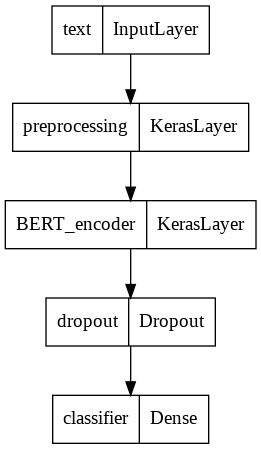

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='categorical_crossentropy')
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
metrics.append(tf.keras.metrics.Precision())
metrics.append(tf.keras.metrics.Recall())
metrics.append(tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None))


### Prepare train and test dataset

In [ ]:
frame = { 'X_train': X_train500, 'y_train': y_train500 }
train_df = pd.DataFrame(frame)
train_df.columns = ["text", "labels"]
train_df

text  labels
0    a sunny day so I got nowhere to hide Not a clo...       4
1    Tell me a tale that always was Sing me a song ...       9
2    like a conversation where stops to breathe Is ...       4
3    Locked up tight Like I would never feel again ...       4
4    sittin in the crib dreamin about leer jets and...       6
..                                                 ...     ...
495  it for the money no it for the fun a plan a sc...       5
496  Another East Bay night Bay Bay Bay When the su...       5
497  a prophet on a mountain and making up dinner W...       5
498  A fiction romance I love this love story That ...       5
499  ve heard it all before ve learning to ignore Y...       5

[500 rows x 2 columns]

In [ ]:
for i, token_list in split0['X_test'].items():
  split0['X_test'][i] = ' '.join(token_list)

frame = { 'X_test': split0['X_test'], 'y_test': split0['y_test'] }
eval_df = pd.DataFrame(frame)
eval_df.columns = ["text", "labels"]
eval_df

text  labels
2      A buh A buh You went to school to learn girl T...       4
4      Say the words I cannot say Say them on another...       7
5      I was alone I was made of stone You took me ho...       4
9      Again the burden of losing rests upon my shoul...       7
20     only been three weeks And a bag of speed from ...       1
...                                                  ...     ...
13517  Like the legend of the Phoenix All ends with b...       4
13522  Mr Telephone man something wrong with my line ...       9
13526  can you imagine what it would be like we never...       4
13532  Love of my life hurt me broken my heart and no...       7
13535  think what afraid of come in you know been mad...       3

[2708 rows x 2 columns]

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
import numpy as np
batch_size = 32
steps_per_epoch = int(np.ceil(len(train_df)/float(batch_size) ) )
print('each epoch has ' , steps_per_epoch, ' steps')

each epoch has  16  steps


In [ ]:
epochs = 5

#steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


ValueError: ignored

### Preprocess my lyrics data (Official train and test)

In [ ]:
import tensorflow as tf

In [ ]:
SEQ_LEN = 512

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 


In [ ]:
df_genre_by_lang.shape

(13540, 6)

In [ ]:
X_lyrics = df_genre_by_lang['lyric']
print(type(X_lyrics[0]))
y_genres = df_genre_by_lang['genres']
print(type(y_genres[0]))

<class 'str'>
<class 'str'>


In [ ]:
y_genres

0                      pop
1                     soul
2                      pop
3                      pop
4                     rock
               ...        
13535           indie rock
13536                  pop
13537           indie rock
13538                  pop
13539    singer-songwriter
Name: genres, Length: 13540, dtype: object

In [ ]:
y_genres = y_genres.astype('category')
label_mapping = y_genres.cat.categories
y_genres = y_genres.cat.codes
y_genres

0        4
1        9
2        4
3        4
4        7
        ..
13535    3
13536    4
13537    3
13538    4
13539    8
Length: 13540, dtype: int8

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

import numpy as np
Xids = np.zeros((X_lyrics.shape[0], SEQ_LEN))
Xmask = np.zeros((X_lyrics.shape[0], SEQ_LEN))

In [ ]:
Xids.shape

(13540, 512)

In [ ]:
for i, lyric in enumerate(X_lyrics):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids[i,:], Xmask[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
Xids

array([[  101.,   170., 21162., ...,     0.,     0.,     0.],
       [  101.,  4630.,  1143., ...,     0.,     0.,     0.],
       [  101.,   138.,   171., ...,     0.,     0.,     0.],
       ...,
       [  101.,  9859., 13335., ...,     0.,     0.,     0.],
       [  101.,  4537.,  1128., ...,     0.,     0.,     0.],
       [  101.,   192.,  2246., ...,     0.,     0.,     0.]])

Note: 101 means the initial char.

In [ ]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Create y labels in transformer format

In [ ]:
labels = np.zeros((y_genres.shape[0], 10))
labels.shape

(13540, 10)

We want one hot label, instead of integer.

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
labels[ np.arange(y_genres.shape[0]), y_genres.values] =1
labels

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [ ]:
labels

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

for i in dataset.take(1):
  print(i)
  

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101.,   170., 21162.,  1285.,  1177.,   146.,  1400.,  8251.,
        1106.,  4750.,  1753.,   170.,  7180.,  1107.,  1103.,  3901.,
        1573., 12714.,  1400.,  1380.,  1107.,  1139.,  1257.,  2066.,
        1177.,  1128.,  1267.,  1143.,  5354.,  1573.,   146.,  3074.,
        1111.,  1103.,  4162.,   184., 10559.,  1706.,  4750.,  1155.,
        1139.,  3632.,  1133.,  1781.,  1315.,  1263.,  1252.,   146.,
        1576.,  1111.,  1103.,  1442.,   184., 10559.,  1191.,  1128.,
        1341.,  4780.,  1173.,  1115.,  2228.,  1128.,  2012.,  4458.,
        1113.,  1103.,  3945.,  1104.,  1113.,  1176.,  2613.,  1107.,
         170.,  2937.,  4842.,  4458.,  1113.,  1129.,  2288.,  1223.,
        4458.,  1113., 12120.,  1116., 13830.,  4862.,  1139.,  3632.,
        1177.,  1115.,  1309.,  1267.,  2421.,  1122.,  4458.,  1122.,
        4458.,  1519.,  1122.,  4458.,  1113.,  1143.,  1519.,  1122.,
        4458.,  1519.,  1122

In [ ]:
Xid_list=[]
y_onehot_list=[]
for item in dataset.take(1):
  print('Xid: ', item[0])
  print('Label:', item[2])

Xid:  tf.Tensor(
[  101.   170. 21162.  1285.  1177.   146.  1400.  8251.  1106.  4750.
  1753.   170.  7180.  1107.  1103.  3901.  1573. 12714.  1400.  1380.
  1107.  1139.  1257.  2066.  1177.  1128.  1267.  1143.  5354.  1573.
   146.  3074.  1111.  1103.  4162.   184. 10559.  1706.  4750.  1155.
  1139.  3632.  1133.  1781.  1315.  1263.  1252.   146.  1576.  1111.
  1103.  1442.   184. 10559.  1191.  1128.  1341.  4780.  1173.  1115.
  2228.  1128.  2012.  4458.  1113.  1103.  3945.  1104.  1113.  1176.
  2613.  1107.   170.  2937.  4842.  4458.  1113.  1129.  2288.  1223.
  4458.  1113. 12120.  1116. 13830.  4862.  1139.  3632.  1177.  1115.
  1309.  1267.  2421.  1122.  4458.  1122.  4458.  1519.  1122.  4458.
  1113.  1143.  1519.  1122.  4458.  1519.  1122.  4458.  1113.  2421.
  1122.  4458.  3632.  1132.  1103. 10465.  1105.  4235.  1268.  1106.
  1103.  2421.  1122.  4458.  1122.  4458.  1519.  1122.  4458.  1113.
  1143.  1519.  1122.  4458.  1519.  1122.  4458.  1113.  24

In [ ]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [ ]:
dataset = dataset.map(map_func)
for i in dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101.,   170., 21162.,  1285.,  1177.,   146.,  1400.,  8251.,
        1106.,  4750.,  1753.,   170.,  7180.,  1107.,  1103.,  3901.,
        1573., 12714.,  1400.,  1380.,  1107.,  1139.,  1257.,  2066.,
        1177.,  1128.,  1267.,  1143.,  5354.,  1573.,   146.,  3074.,
        1111.,  1103.,  4162.,   184., 10559.,  1706.,  4750.,  1155.,
        1139.,  3632.,  1133.,  1781.,  1315.,  1263.,  1252.,   146.,
        1576.,  1111.,  1103.,  1442.,   184., 10559.,  1191.,  1128.,
        1341.,  4780.,  1173.,  1115.,  2228.,  1128.,  2012.,  4458.,
        1113.,  1103.,  3945.,  1104.,  1113.,  1176.,  2613.,  1107.,
         170.,  2937.,  4842.,  4458.,  1113.,  1129.,  2288.,  1223.,
        4458.,  1113., 12120.,  1116., 13830.,  4862.,  1139.,  3632.,
        1177.,  1115.,  1309.,  1267.,  2421.,  1122.,  4458.,  1122.,
        4458.,  1519.,  1122.,  4458.,  1113.,  1143.,  1519.,  1122.,
        4458.,

In [ ]:
dataset = dataset.shuffle(42).batch(32)
DS_LEN = len(list(dataset))
DS_LEN

424

424 because 13000/32

In [ ]:
SPLIT = 0.8
round(DS_LEN*SPLIT)

339

In [ ]:
train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))#remainer is for val.

### Imbalance

In [ ]:
counter = Counter(y_genres)
sum = sum(counter.values())
sum

13540

In [ ]:
MAX = max(counter.values())
MAX

5179

In [ ]:
my_weight={}

for genre in range(10):
  my_weight[genre]=MIN/counter[genre]
#sum(weight)
my_weight

{0: 0.40083945435466944,
 1: 0.4426419466975666,
 2: 0.5684523809523809,
 3: 0.35337650323774283,
 4: 0.07375941301409539,
 5: 1.0,
 6: 0.39059304703476483,
 7: 0.2636300897170462,
 8: 0.5496402877697841,
 9: 0.296583850931677}

### Use base bert

In [ ]:
SEQ_LEN

512

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask')

embeddings = bert(input_ids, attention_mask= mask)[0]


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


By the way, [0] is the last hidden state, and [1] is the pooled output.

In [ ]:
bert(input_ids, attention_mask= mask)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [ ]:
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

BERT is huge, so here we don't fine tune BERT. Simply use pre-trained base BERT

In [ ]:
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
#metrics.append(tf.keras.metrics.Precision())
#metrics.append(tf.keras.metrics.Recall())
#metrics.append(tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy', dtype=None))

model.compile(optimizer=optimizer, loss= loss, metrics=metrics)

In [ ]:
train.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>

In [ ]:
print(DS_LEN, len(train), len(val), len(train)+ len(val))

424 339 85 424


In [ ]:
VAL_SIZE = len(val)*32
VAL_SIZE

2720

In [ ]:
val.

AttributeError: ignored

In [ ]:
#print(len(val.take(len(val))))
for item, label_batch in val.take(1):#len(val)
  print(item['input_ids'])
  #one_batch= item[0]['input_ids']
  #for xids in one_batch:
  #  print(xids.shape)

tf.Tensor(
[[  101.  1422.  8819.  3816.  1106.  3170.  1105.   146.  1221.   146.
  13224.  1243.  1146.  1149.  1104.  1908.  2431.  1463.  1897.  2215.
   1303.  1939.  1987.  8517.   170. 27481.  1194.  1139.  1716.   146.
   1920.  1337.  1139.  3459.  1256.  1801.  2052.  1136.  6100.  3994.
   1164.  1115.   146. 16445.  1129.  9994.  1950.  2033.  4871.  1104.
   1991. 17837.  5671.  1103.  1285.  1177.  2080.  1155.  1139.  3675.
  19642.  1437.  1146.  1523.  1191.   146.  1437.  1146.  1120.  1155.
  12528.  1199.  1159.  1106.  5683.  1177.  1321.  1122.  7572.   139.
   7609.  1162.  1122.  1113.  1103. 19398.  1107.  1143.  1103.  2197.
   2215.  1120.  1313. 18292.  1103.  3581.  1155.  2041.   146.  1328.
   1185.  1419.   146.  1400.  1139.  2092.  1105.  1139.  1794.  2864.
   1107.  4932.  1103. 13151.  1113.  1103.  1837.   146.  1920.  1164.
   1103.  6477.  2052.  1774.  1662.  1106.  5042.   146. 16445.  1129.
   9994.  1950.  2033.  4871.  1104.  1991. 17837.  5

In [ ]:
def map_func_only_X(val_dictionary, labels):
  return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}

In [ ]:
val_X = val.map(map_func_only_X)
print(len(val_X))
#for i in val_X.take(1):
  #print(i)

85


In [ ]:
def map_func_only_y(val_dictionary, labels):
  return labels

In [ ]:
val_y = val.map(map_func_only_y)
print(len(val_y))
y_category=np.zeros((VAL_SIZE, ))
counter=0
for label_tensor in val_y.take(1):
  #print(label_tensor)
  y_val = np.argmax(label_tensor, axis=1)
  for label in y_val:
    print(label) 
    y_category[counter]=label
    counter+=1
print('counter:',counter)
print(y_category)

85
2
4
4
4
8
9
6
4
8
9
7
4
1
1
4
4
4
5
4
7
4
1
6
4
4
4
3
9
4
3
8
7
counter: 32
[2. 4. 4. 4. 8. 9. 6. 4. 8. 9. 7. 4. 1. 1. 4. 4. 4. 5. 4. 7. 4. 1. 6. 4.
 4. 4. 3. 9. 4. 3. 8. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
test_label = np.zeros(( 32,10))
for item, batch_label in val.take(1):
  for i, label in enumerate(batch_label):
    test_label[i,:] = label
  print(test_label)
  

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [ ]:
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

Ref1: how to calculate genre as int instead of one hot vector from list of one hot vectors.
https://www.sharpsightlabs.com/blog/numpy-argmax/

Ref2: How to use self-programmed metrics: https://stackoverflow.com/questions/37657260/how-to-implement-custom-metric-in-keras



In [ ]:
VAL_SIZE=2692

In [ ]:
from sklearn.metrics import balanced_accuracy_score
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []
        self.validation_data = val

    def map_func_only_X(val_dictionary, labels):
      return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}
    def map_func_only_y(val_dictionary, labels):
      return labels

    def on_epoch_end(self, batch, logs={}):
      #Xid_list= np.zeros((VAL_SIZE, SEQ_LEN))
      #y_onehot_list= np.zeros((VAL_SIZE, 10))
      #counter=0
      #for item in dataset.take(len(self.validation_data)):
      #for item in val.take(len(val)):
      """
      for item, batch_label in self.validation_data.take(len(val)):
        for label in batch_label:
          y_onehot_list[counter,:] = label
          counter+=1
        one_batch_xid = item['input_ids']
        for xids in one_batch_xid:
          Xid_list[counter, :] = xids
        
        #X_val, y_val = self.validation_data[0], self.validation_data[1]
      """
      val_y = self.validation_data.map(map_func_only_y)
      y_category=np.zeros((VAL_SIZE, ))
      counter=0
      for label_tensor in val_y.take(len(val_y)):
        y_val = np.argmax(label_tensor, axis=1)
        for label in y_val:
          y_category[counter]=label
          counter+=1
      X_val, y_val =self.validation_data.map(map_func_only_X), y_category
      y_predict = np.asarray(model.predict(X_val))

      #y_val = np.argmax(y_val, axis=1)#I have already done converting to category
      y_predict = np.argmax(y_predict, axis=1)

      self._data.append({
          'balanced_accuracy': balanced_accuracy_score(y_val, y_predict),
          #'val_rocauc': roc_auc_score(y_val, y_predict),
      })
      return

    def get_data(self):
        return self._data

### fit and test, without using balanced accuracy

In [ ]:
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
339/339 [==============================] - 203s 557ms/step - loss: 1.8402 - categorical_accuracy: 0.4064 - val_loss: 1.7468 - val_categorical_accuracy: 0.4146
Epoch 2/10
339/339 [==============================] - 186s 548ms/step - loss: 1.7097 - categorical_accuracy: 0.4303 - val_loss: 1.7665 - val_categorical_accuracy: 0.4146
Epoch 3/10
339/339 [==============================] - 186s 548ms/step - loss: 1.6922 - categorical_accuracy: 0.4310 - val_loss: 1.7833 - val_categorical_accuracy: 0.4105
Epoch 4/10
339/339 [==============================] - 186s 549ms/step - loss: 1.6851 - categorical_accuracy: 0.4322 - val_loss: 1.7849 - val_categorical_accuracy: 0.4216
Epoch 5/10
339/339 [==============================] - 186s 550ms/step - loss: 1.7008 - categorical_accuracy: 0.4295 - val_loss: 1.7688 - val_categorical_accuracy: 0.4205
Epoch 6/10
339/339 [==============================] - 186s 548ms/step - loss: 1.6973 - categorical_accuracy: 0.4328 - val_loss: 1.7532 - val_categoric

It took 31 min.

### Use my self programmed balanced accuracy

In [ ]:
metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight ,callbacks=[metrics])
metrics.get_data()

Epoch 1/10
339/339 [==============================] - 225s 645ms/step - loss: 0.5565 - categorical_accuracy: 0.3878 - val_loss: 1.9337 - val_categorical_accuracy: 0.3273
Epoch 2/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5397 - categorical_accuracy: 0.3626 - val_loss: 2.0651 - val_categorical_accuracy: 0.2764
Epoch 3/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5375 - categorical_accuracy: 0.3392 - val_loss: 2.0931 - val_categorical_accuracy: 0.2273
Epoch 4/10
339/339 [==============================] - 218s 645ms/step - loss: 0.5378 - categorical_accuracy: 0.3197 - val_loss: 2.0576 - val_categorical_accuracy: 0.2459
Epoch 5/10
339/339 [==============================] - 219s 645ms/step - loss: 0.5333 - categorical_accuracy: 0.3077 - val_loss: 2.0292 - val_categorical_accuracy: 0.2816
Epoch 6/10
339/339 [==============================] - 219s 646ms/step - loss: 0.5373 - categorical_accuracy: 0.2967 - val_loss: 2.1738 - val_categoric

[{'balanced_accuracy': 0.09744849916749872},
 {'balanced_accuracy': 0.10420636932765996},
 {'balanced_accuracy': 0.10970405736872939},
 {'balanced_accuracy': 0.10356561320774078},
 {'balanced_accuracy': 0.10792864804613309},
 {'balanced_accuracy': 0.09168989857066105},
 {'balanced_accuracy': 0.09926135499834263},
 {'balanced_accuracy': 0.10014630125778516},
 {'balanced_accuracy': 0.09807505457274496},
 {'balanced_accuracy': 0.09881853716030842}]

## From here, separate X_train, X_test from KFOldSplit

### Preprocess my lyrics data (Official train and test)

In [ ]:
import tensorflow as tf
!pip3 install transformers
SEQ_LEN = 256#512

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.9 MB/s 
     |████████████████████████████████| 120 kB 87.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.3 MB/s 


In [ ]:
split0['X_test']

2        [A, buh, A, buh, You, went, to, school, to, le...
4        [Say, the, words, I, cannot, say, Say, them, o...
5        [I, was, alone, I, was, made, of, stone, You, ...
9        [Again, the, burden, of, losing, rests, upon, ...
20       [only, been, three, weeks, And, a, bag, of, sp...
                               ...                        
13517    [Like, the, legend, of, the, Phoenix, All, end...
13522    [Mr, Telephone, man, something, wrong, with, m...
13526    [can, you, imagine, what, it, would, be, like,...
13532    [Love, of, my, life, hurt, me, broken, my, hea...
13535    [think, what, afraid, of, come, in, you, know,...
Name: texts, Length: 2708, dtype: object

In [ ]:
def prepare_lyrics(X_series):
  for i, token_list in X_series.items():
    if type(token_list) is list:
      X_series.loc[i] = ' '.join(token_list)
  return X_series

In [ ]:
split0['X_test'] = prepare_lyrics(split0['X_test'] )
split0['X_test']

2        A buh A buh You went to school to learn girl T...
4        Say the words I cannot say Say them on another...
5        I was alone I was made of stone You took me ho...
9        Again the burden of losing rests upon my shoul...
20       only been three weeks And a bag of speed from ...
                               ...                        
13517    Like the legend of the Phoenix All ends with b...
13522    Mr Telephone man something wrong with my line ...
13526    can you imagine what it would be like we never...
13532    Love of my life hurt me broken my heart and no...
13535    think what afraid of come in you know been mad...
Name: texts, Length: 2708, dtype: object

In [ ]:
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_train'] 

0        a sunny day so I got nowhere to hide Not a clo...
1        Tell me a tale that always was Sing me a song ...
3        like a conversation where stops to breathe Is ...
6        Locked up tight Like I would never feel again ...
7        sittin in the crib dreamin about leer jets and...
                               ...                        
13534    grandma cookies nigga Shout out to fronto leaf...
13536    Oh yeah yeah Last night I took a walk in the s...
13537    Innocence it come easy in a sense it never wil...
13538    Girl you know how I feel I really Since you be...
13539    wwI oh must go on standing You break that whic...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train'] 

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

import numpy as np
Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']
print(Xids_train.shape, Xids_test.shape)

(10832, 256) (2708, 256)


In [ ]:
Xids_train[0]

array([  101.,   170., 21162.,  1285.,  1177.,   146.,  1400.,  8251.,
        1106.,  4750.,  1753.,   170.,  7180.,  1107.,  1103.,  3901.,
        1573., 12714.,  1400.,  1380.,  1107.,  1139.,  1257.,  2066.,
        1177.,  1128.,  1267.,  1143.,  5354.,  1573.,   146.,  3074.,
        1111.,  1103.,  4162.,   184., 10559.,  1706.,  4750.,  1155.,
        1139.,  3632.,  1133.,  1781.,  1315.,  1263.,  1252.,   146.,
        1576.,  1111.,  1103.,  1442.,   184., 10559.,  1191.,  1128.,
        1341.,  4780.,  1173.,  1115.,  2228.,  1128.,  2012.,  4458.,
        1113.,  1103.,  3945.,  1104.,  1113.,  1176.,  2613.,  1107.,
         170.,  2937.,  4842.,  4458.,  1113.,  1129.,  2288.,  1223.,
        4458.,  1113., 12120.,  1116., 13830.,  4862.,  1139.,  3632.,
        1177.,  1115.,  1309.,  1267.,  2421.,  1122.,  4458.,  1122.,
        4458.,  1519.,  1122.,  4458.,  1113.,  1143.,  1519.,  1122.,
        4458.,  1519.,  1122.,  4458.,  1113.,  2421.,  1122.,  4458.,
      

Create y labels in transformer format

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
"""
for Xids_train, Xmask_train, labels_train in dataset_train.take(1):
  print(labels_train)

print(labels_train.shape)
"""

'\nfor Xids_train, Xmask_train, labels_train in dataset_train.take(1):\n  print(labels_train)\n\nprint(labels_train.shape)\n'

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

import numpy as np

Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

In [ ]:
len(dataset_train)

10832

In [ ]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [ ]:
dataset_train = dataset_train.map(map_func)

for i in dataset_train.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(256,), dtype=float64, numpy=
array([  101.,   170., 21162.,  1285.,  1177.,   146.,  1400.,  8251.,
        1106.,  4750.,  1753.,   170.,  7180.,  1107.,  1103.,  3901.,
        1573., 12714.,  1400.,  1380.,  1107.,  1139.,  1257.,  2066.,
        1177.,  1128.,  1267.,  1143.,  5354.,  1573.,   146.,  3074.,
        1111.,  1103.,  4162.,   184., 10559.,  1706.,  4750.,  1155.,
        1139.,  3632.,  1133.,  1781.,  1315.,  1263.,  1252.,   146.,
        1576.,  1111.,  1103.,  1442.,   184., 10559.,  1191.,  1128.,
        1341.,  4780.,  1173.,  1115.,  2228.,  1128.,  2012.,  4458.,
        1113.,  1103.,  3945.,  1104.,  1113.,  1176.,  2613.,  1107.,
         170.,  2937.,  4842.,  4458.,  1113.,  1129.,  2288.,  1223.,
        4458.,  1113., 12120.,  1116., 13830.,  4862.,  1139.,  3632.,
        1177.,  1115.,  1309.,  1267.,  2421.,  1122.,  4458.,  1122.,
        4458.,  1519.,  1122.,  4458.,  1113.,  1143.,  1519.,  1122.,
        4458.,

In [ ]:
dataset_test = dataset_test.map(map_func)
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [ ]:
dataset_train = dataset_train.shuffle(42).batch(32)
DS_LEN = len(list(dataset_train))
DS_LEN

339

339 because 10800/32

In [ ]:
SPLIT = 0.9
round(DS_LEN*SPLIT)

305

In [ ]:
len(split0['X_train'])-int(len(split0['X_train'])*0.9)

1084

In [ ]:
train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))#remainer is for val.

In [ ]:
test = dataset_test.batch(32)

In [ ]:
def map_func_only_X(val_dictionary, labels):
  return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}

In [ ]:
def map_func_only_y(val_dictionary, labels):
  return labels

In [ ]:
VAL_SIZE=1088

In [ ]:
counter = Counter(split0['y_train'])
SUM=0
for item in list(counter.values()) :
  SUM+=item
#SUM = sum(counter.values())
SUM

10832

In [ ]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)

for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({4: 4143, 7: 1159, 9: 1030, 3: 865, 6: 783, 0: 763, 1: 690, 8: 556, 2: 537, 5: 306})


{4: 0.2614530533429882,
 9: 1.051650485436893,
 6: 1.383397190293742,
 2: 2.0171322160148977,
 0: 1.4196592398427261,
 7: 0.9345987920621226,
 1: 1.569855072463768,
 5: 3.539869281045752,
 8: 1.948201438848921,
 3: 1.2522543352601156}

### Imbalance

In [ ]:
MAX = max(counter.values())
MAX

4143

In [ ]:
my_weight={}

for genre in range(10):
  my_weight[genre]=MAX/counter[genre]
#sum(weight)
my_weight

{0: 5.4298820445609435,
 1: 6.004347826086956,
 2: 7.715083798882682,
 3: 4.789595375722543,
 4: 1.0,
 5: 13.53921568627451,
 6: 5.291187739463601,
 7: 3.5746333045729077,
 8: 7.451438848920863,
 9: 4.022330097087378}

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask')

embeddings = bert(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

BERT is huge, so here we don't fine tune BERT. Simply use pre-trained base BERT

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model.compile(optimizer=optimizer, loss= loss, metrics=metrics)

In [ ]:
print(DS_LEN, len(train), len(val), len(test))

339 305 34 85


In [ ]:
VAL_SIZE = len(val)*32
VAL_SIZE

1088

In [ ]:
#print(len(val.take(len(val))))
for item, label_batch in val.take(1):#len(val)
  print(item['input_ids'])
  #one_batch= item[0]['input_ids']
  #for xids in one_batch:
  #  print(xids.shape)

In [ ]:
val_X = val.map(map_func_only_X)
print(len(val_X))
#for i in val_X.take(1):
  #print(i)

34


In [ ]:
val_y = val.map(map_func_only_y)
print(len(val_y))
y_category=np.zeros((VAL_SIZE, ))
counter=0
for label_tensor in val_y.take(1):
  #print(label_tensor)
  y_val = np.argmax(label_tensor, axis=1)
  for label in y_val:
    print(label) 
    y_category[counter]=label
    counter+=1
print('counter:',counter)
print(y_category)

In [ ]:
VAL_SIZE=1072
VAL_SIZE

1072

In [ ]:
VAL_SIZE=len(split0['X_train'])-int(len(split0['X_train'])*0.9)
VAL_SIZE

1084

In [ ]:
val_y = val2.map(map_func_only_y)
print(len(val_y))
y_category=np.zeros((VAL_SIZE, ))
counter=0
for label_tensor in val_y.take(len(val2)):
  #print(label_tensor)
  y_val = np.argmax(label_tensor, axis=1)
  for label in y_val:
    print(label) 
    y_category[counter]=label
    counter+=1
print('counter:',counter)
print(y_category)

68
4
6
2
5
4
6
7
1
0
7
3
4
4
7
4
4
9
0
4
5
8
7
5
4
4
3
3
0
4
7
9
1
2
7
9
4
4
4
4
6
6
4
4
8
4
0
3
4
0
9
4
4
9
4
0
4
4
9
6
7
2
4
4
9
4
6
6
3
7
4
4
2
0
3
1
0
3
4
9
4
3
9
8
4
8
5
4
4
4
3
4
4
3
1
4
7
4
9
4
5
8
4
3
9
4
4
4
4
2
7
7
0
7
0
4
4
3
1
7
4
4
7
9
4
4
4
7
9
4
8
4
7
7
5
1
4
4
4
9
4
1
2
4
6
7
4
4
0
7
6
0
4
5
7
4
4
9
9
2
4
9
6
4
0
7
1
4
4
0
4
4
0
7
4
7
7
4
3
3
8
4
3
6
1
6
7
2
2
2
0
6
7
4
4
7
4
2
4
7
3
4
5
7
5
4
3
4
6
7
2
7
6
4
7
6
7
9
1
7
4
4
6
6
6
3
4
0
5
1
0
6
7
3
5
4
5
4
1
6
4
1
8
4
8
6
7
9
9
2
9
4
4
7
4
4
7
4
4
4
4
3
4
0
8
4
4
9
4
7
9
4
4
4
0
6
4
4
6
7
0
9
7
6
4
4
4
9
6
4
7
9
8
7
4
3
4
4
0
9
4
4
4
4
3
7
4
0
7
4
4
2
0
3
4
8
0
4
2
0
8
3
0
6
2
4
1
4
5
4
4
4
8
3
6
4
7
4
4
1
4
4
0
9
9
6
3
4
3
4
4
4
4
1
4
8
2
3
6
4
3
4
7
7
9
7
3
4
4
9
1
1
4
4
9
6
3
4
6
3
2
4
5
4
4
9
4
3
2
8
4
4
4
4
7
7
8
4
7
9
0
6
8
4
1
9
0
7
4
2
8
9
9
4
4
4
6
8
9
7
4
9
4
7
4
0
4
4
9
8
4
1
7
3
1
7
7
0
0
0
2
4
4
8
4
4
7
4
3
4
2
4
2
8
9
4
1
8
9
4
4
4
9
3
4
2
8
7
4
7
1
0
9
6
4
1
9
4
9
5
7
2
4
4
7
6
9
7
4
9
3
9
3
9
7
4
9
7
4
1

Ref1: how to calculate genre as int instead of one hot vector from list of one hot vectors.
https://www.sharpsightlabs.com/blog/numpy-argmax/

Ref2: How to use self-programmed metrics: https://stackoverflow.com/questions/37657260/how-to-implement-custom-metric-in-keras



In [ ]:
VAL_SIZE=1072

In [ ]:
from sklearn.metrics import balanced_accuracy_score
class Metrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []
        self.validation_data = val2

    def map_func_only_X(val_dictionary, labels):
      return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}
    def map_func_only_y(val_dictionary, labels):
      return labels

    def on_epoch_end(self, batch, logs={}):
      #Xid_list= np.zeros((VAL_SIZE, SEQ_LEN))
      #y_onehot_list= np.zeros((VAL_SIZE, 10))
      #counter=0
      #for item in dataset.take(len(self.validation_data)):
      #for item in val.take(len(val)):
      """
      for item, batch_label in self.validation_data.take(len(val)):
        for label in batch_label:
          y_onehot_list[counter,:] = label
          counter+=1
        one_batch_xid = item['input_ids']
        for xids in one_batch_xid:
          Xid_list[counter, :] = xids
        
        #X_val, y_val = self.validation_data[0], self.validation_data[1]
      """
      val_y = self.validation_data.map(map_func_only_y)
      y_category=np.zeros((VAL_SIZE, ))
      counter=0
      for label_tensor in val_y.take(len(val_y)):
        y_val = np.argmax(label_tensor, axis=1)
        for label in y_val:
          y_category[counter]=label
          counter+=1
      X_val, y_val =self.validation_data.map(map_func_only_X), y_category
      y_predict = np.asarray(model2.predict(X_val))

      #y_val = np.argmax(y_val, axis=1)#I have already done converting to category
      y_predict = np.argmax(y_predict, axis=1)

      self._data.append({
          'balanced_accuracy': balanced_accuracy_score(y_val, y_predict),
          #'val_rocauc': roc_auc_score(y_val, y_predict),
      })
      return

    def get_data(self):
        return self._data

### Transfer learning: try early stopping with SEQ_LEN=512

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)

metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight ,callbacks=[metrics, early_stopping])
metrics.get_data()

Epoch 1/10
305/305 [==============================] - 165s 541ms/step - loss: 7.4384 - categorical_accuracy: 0.2784 - val_loss: 2.1002 - val_categorical_accuracy: 0.2118
Epoch 2/10
305/305 [==============================] - 165s 541ms/step - loss: 7.0577 - categorical_accuracy: 0.3053 - val_loss: 2.0583 - val_categorical_accuracy: 0.2435
Epoch 3/10
305/305 [==============================] - 165s 542ms/step - loss: 6.7958 - categorical_accuracy: 0.3207 - val_loss: 1.9879 - val_categorical_accuracy: 0.2677
Epoch 4/10
305/305 [==============================] - 165s 542ms/step - loss: 6.5908 - categorical_accuracy: 0.3376 - val_loss: 2.0138 - val_categorical_accuracy: 0.2388
Epoch 5/10
305/305 [==============================] - 165s 542ms/step - loss: 6.4173 - categorical_accuracy: 0.3493 - val_loss: 2.0363 - val_categorical_accuracy: 0.2472
Epoch 6/10
305/305 [==============================] - 165s 542ms/step - loss: 6.2501 - categorical_accuracy: 0.3629 - val_loss: 2.0147 - val_categoric

[{'balanced_accuracy': 0.10064757124688836},
 {'balanced_accuracy': 0.1187677795399048},
 {'balanced_accuracy': 0.09990412917019217},
 {'balanced_accuracy': 0.08602748843296298},
 {'balanced_accuracy': 0.12293896335258817},
 {'balanced_accuracy': 0.08466265273217208}]

In [ ]:
TEST_SIZE = split0["y_test"].shape[0]
TEST_SIZE

2708

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
test_y = test.map(map_func_only_y)
y_category=np.zeros((TEST_SIZE, ))
counter=0
for label_tensor in test_y.take(len(test_y)):
  y_test = np.argmax(label_tensor, axis=1)
  for label in y_test:
    y_category[counter]=label
    counter+=1

X_test, y_test = test.map(map_func_only_X), y_category
y_predict_test = np.asarray(model.predict(X_test))
y_predict_test = np.argmax(y_predict_test, axis=1)
print(classification_report(y_test, y_predict_test) )
print(balanced_accuracy_score(y_test, y_predict_test))

              precision    recall  f1-score   support

         0.0       0.14      0.42      0.21       190
         1.0       0.16      0.28      0.20       173
         2.0       0.10      0.14      0.12       135
         3.0       0.13      0.17      0.15       216
         4.0       0.74      0.19      0.31      1036
         5.0       0.12      0.38      0.18        76
         6.0       0.77      0.77      0.77       195
         7.0       0.11      0.08      0.10       290
         8.0       0.09      0.09      0.09       139
         9.0       0.24      0.28      0.26       258

    accuracy                           0.25      2708
   macro avg       0.26      0.28      0.24      2708
weighted avg       0.42      0.25      0.26      2708

0.2825509565558356


### Transfer learning -> Fine tunine: unfreeze middle layers and train with smaller learning rate.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
SEQ_LEN2=256
import numpy as np
Xids_train2 = np.zeros((split0['X_train'].shape[0], SEQ_LEN2))
Xmask_train2 = np.zeros((split0['X_train'].shape[0], SEQ_LEN2))
#Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
#Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN2, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train2[i,:], Xmask_train2[i,:] = tokens['input_ids'], tokens['attention_mask']

#for i, lyric in enumerate(split0['X_test']):
#  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN2, truncation =True, padding="max_length"
#    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
#  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']
print(Xids_train2.shape,)

(10832, 256)


In [ ]:
from transformers import TFAutoModel
roberta = TFAutoModel.from_pretrained('roberta-base')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model2 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model2.layers[2].trainable = False
model2.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
print(Xids_train2.shape)

(10832, 256)


In [ ]:
labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_train

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [ ]:
Xids_train2[0]

In [ ]:
#labels_train = np.zeros((split0['y_train'].shape[0], 10))
#labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1

dataset_train2 = tf.data.Dataset.from_tensor_slices((Xids_train2, Xmask_train2, labels_train))
dataset_train2 = dataset_train2.map(map_func)
dataset_train2 = dataset_train2.shuffle(42).batch(16)

SPLIT=0.9
DS_LEN = len(dataset_train2)
print("DS_LEN:", DS_LEN)

train2 = dataset_train2.take(round(DS_LEN*SPLIT))
val2 = dataset_train2.skip(round(DS_LEN*SPLIT))#remainer is for val.

DS_LEN: 677


In [ ]:
print(len(train2), len(val2))

609 68


First, transfer learning

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model2.compile(optimizer=optimizer, loss= loss, metrics=metrics)
model2.summary() #Check trainable params increased.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
VAL_SIZE=1088

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)

#metrics = Metrics()
history = model2.fit(train2, validation_data=val2, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])#metrics
#metrics.get_data()

Epoch 1/6
609/609 [==============================] - 94s 134ms/step - loss: 2.1050 - categorical_accuracy: 0.2384 - val_loss: 2.5287 - val_categorical_accuracy: 0.1305
Epoch 2/6
609/609 [==============================] - 79s 130ms/step - loss: 1.9531 - categorical_accuracy: 0.2923 - val_loss: 2.6360 - val_categorical_accuracy: 0.1167
Epoch 3/6
609/609 [==============================] - 79s 130ms/step - loss: 1.9067 - categorical_accuracy: 0.2974 - val_loss: 2.3261 - val_categorical_accuracy: 0.1434
Epoch 4/6
609/609 [==============================] - 79s 130ms/step - loss: 1.8769 - categorical_accuracy: 0.3051 - val_loss: 2.2580 - val_categorical_accuracy: 0.1682
Epoch 5/6
609/609 [==============================] - 79s 130ms/step - loss: 1.8385 - categorical_accuracy: 0.3131 - val_loss: 2.3655 - val_categorical_accuracy: 0.1811
Epoch 6/6
609/609 [==============================] - 79s 129ms/step - loss: 1.8289 - categorical_accuracy: 0.3206 - val_loss: 2.1423 - val_categorical_accuracy:

In [ ]:
TEST_SIZE = split0["y_test"].shape[0]
TEST_SIZE

2708

In [ ]:
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN2))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN2))
for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN2, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test = dataset_test.map(map_func)
test = dataset_test.batch(16)

In [ ]:
get_balanced_accuracy(model2)

              precision    recall  f1-score   support

         0.0       0.14      0.15      0.15       190
         1.0       0.18      0.14      0.16       173
         2.0       0.07      0.05      0.06       135
         3.0       0.14      0.25      0.18       216
         4.0       0.75      0.03      0.07      1036
         5.0       0.08      0.58      0.15        76
         6.0       0.43      0.84      0.57       195
         7.0       0.19      0.03      0.06       290
         8.0       0.09      0.29      0.14       139
         9.0       0.22      0.38      0.28       258

    accuracy                           0.19      2708
   macro avg       0.23      0.28      0.18      2708
weighted avg       0.40      0.19      0.15      2708

0.27578776890249534


Fine tuning with smaller learning rate

In [ ]:
# Unfreeze the base model
#model.trainable = True
model2.layers[2].trainable = True

# It's important to recompile your model after you make any changes
optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model2.compile(optimizer=optimizer, loss= loss, metrics=metrics)
model2.summary() #Check trainable params increased.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
#metrics = Metrics()
history = model2.fit(train2, validation_data=val2, epochs=6, class_weight=my_weight2 ,callbacks=[ early_stopping])#metrics
#metrics.get_data()

Epoch 1/6


609/609 [==============================] - 203s 307ms/step - loss: 1.7488 - categorical_accuracy: 0.3503 - val_loss: 1.9209 - val_categorical_accuracy: 0.3309
Epoch 2/6
609/609 [==============================] - 185s 303ms/step - loss: 1.6219 - categorical_accuracy: 0.3758 - val_loss: 1.8664 - val_categorical_accuracy: 0.3373
Epoch 3/6
609/609 [==============================] - 185s 303ms/step - loss: 1.5014 - categorical_accuracy: 0.4157 - val_loss: 1.8434 - val_categorical_accuracy: 0.2960
Epoch 4/6
609/609 [==============================] - 185s 304ms/step - loss: 1.4113 - categorical_accuracy: 0.4380 - val_loss: 1.8316 - val_categorical_accuracy: 0.3373
Epoch 5/6
609/609 [==============================] - 185s 303ms/step - loss: 1.2980 - categorical_accuracy: 0.4698 - val_loss: 1.8991 - val_categorical_accuracy: 0.3419
Epoch 6/6
609/609 [==============================] - 185s 304ms/step - loss: 1.2123 - categorical_accuracy: 0.5004 - val_loss: 1.7828 - val_categorical_accuracy: 0.3

In [ ]:
get_balanced_accuracy(model2)

              precision    recall  f1-score   support

         0.0       0.26      0.23      0.24       190
         1.0       0.19      0.32      0.24       173
         2.0       0.09      0.25      0.13       135
         3.0       0.25      0.20      0.22       216
         4.0       0.74      0.41      0.53      1036
         5.0       0.23      0.41      0.30        76
         6.0       0.65      0.90      0.76       195
         7.0       0.14      0.01      0.01       290
         8.0       0.13      0.23      0.17       139
         9.0       0.27      0.47      0.34       258

    accuracy                           0.36      2708
   macro avg       0.30      0.34      0.29      2708
weighted avg       0.44      0.36      0.36      2708

0.34310539549600694


### Try different learning rate and class weight

In [ ]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)
print("SUM:", SUM)
for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({4: 4143, 7: 1159, 9: 1030, 3: 865, 6: 783, 0: 763, 1: 690, 8: 556, 2: 537, 5: 306})
SUM: 10832


{4: 0.2614530533429882,
 9: 1.051650485436893,
 6: 1.383397190293742,
 2: 2.0171322160148977,
 0: 1.4196592398427261,
 7: 0.9345987920621226,
 1: 1.569855072463768,
 5: 3.539869281045752,
 8: 1.948201438848921,
 3: 1.2522543352601156}

In [ ]:
#learning_rate=1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)#New!
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model.compile(optimizer=optimizer, loss= loss, metrics=metrics)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)

metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight2 ,callbacks=[metrics, early_stopping])
metrics.get_data()

Epoch 1/10
305/305 [==============================] - 184s 561ms/step - loss: 2.6286 - categorical_accuracy: 0.1101 - val_loss: 2.4429 - val_categorical_accuracy: 0.1101
Epoch 2/10
305/305 [==============================] - 166s 543ms/step - loss: 2.4978 - categorical_accuracy: 0.1270 - val_loss: 2.5052 - val_categorical_accuracy: 0.1175
Epoch 3/10
305/305 [==============================] - 165s 543ms/step - loss: 2.4273 - categorical_accuracy: 0.1461 - val_loss: 2.4666 - val_categorical_accuracy: 0.1362
Epoch 4/10
305/305 [==============================] - 166s 543ms/step - loss: 2.3810 - categorical_accuracy: 0.1579 - val_loss: 2.4322 - val_categorical_accuracy: 0.1455
Epoch 5/10
305/305 [==============================] - 165s 543ms/step - loss: 2.3313 - categorical_accuracy: 0.1748 - val_loss: 2.4089 - val_categorical_accuracy: 0.1595
Epoch 6/10
305/305 [==============================] - 165s 543ms/step - loss: 2.3018 - categorical_accuracy: 0.1837 - val_loss: 2.3841 - val_categoric

[{'balanced_accuracy': 0.09345675855115052},
 {'balanced_accuracy': 0.10264778383673703},
 {'balanced_accuracy': 0.09508081992184837},
 {'balanced_accuracy': 0.12308197160332786},
 {'balanced_accuracy': 0.09630914802065789},
 {'balanced_accuracy': 0.10347840566037467},
 {'balanced_accuracy': 0.11210863180805575},
 {'balanced_accuracy': 0.0786235643867815},
 {'balanced_accuracy': 0.11978332480356244},
 {'balanced_accuracy': 0.10973488557563418}]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

TEST_SIZE = split0["y_test"].shape[0]
test_y = test.map(map_func_only_y)
y_category=np.zeros((TEST_SIZE, ))
counter=0
for label_tensor in test_y.take(len(test_y)):
  y_test = np.argmax(label_tensor, axis=1)
  for label in y_test:
    y_category[counter]=label
    counter+=1

X_test, y_test = test.map(map_func_only_X), y_category
y_predict_test = np.asarray(model.predict(X_test))
y_predict_test = np.argmax(y_predict_test, axis=1)

print(classification_report(y_test, y_predict_test) )
print(balanced_accuracy_score(y_test, y_predict_test))

              precision    recall  f1-score   support

         0.0       0.09      0.14      0.11       190
         1.0       0.13      0.17      0.15       173
         2.0       0.06      0.16      0.09       135
         3.0       0.08      0.11      0.09       216
         4.0       0.65      0.16      0.25      1036
         5.0       0.04      0.22      0.07        76
         6.0       0.41      0.64      0.50       195
         7.0       0.11      0.07      0.09       290
         8.0       0.08      0.18      0.11       139
         9.0       0.12      0.03      0.05       258

    accuracy                           0.17      2708
   macro avg       0.18      0.19      0.15      2708
weighted avg       0.33      0.17      0.18      2708

0.1872912453963657


### Try Learning rate=0.001

In [ ]:
#learning_rate=1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)#New!
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model.compile(optimizer=optimizer, loss= loss, metrics=metrics)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)

metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight2 ,callbacks=[metrics, early_stopping])
metrics.get_data()

Epoch 1/10
305/305 [==============================] - 184s 561ms/step - loss: 2.0906 - categorical_accuracy: 0.2533 - val_loss: 2.1767 - val_categorical_accuracy: 0.1950
Epoch 2/10
305/305 [==============================] - 165s 542ms/step - loss: 1.9176 - categorical_accuracy: 0.2940 - val_loss: 2.1084 - val_categorical_accuracy: 0.2267
Epoch 3/10
305/305 [==============================] - 165s 542ms/step - loss: 1.8304 - categorical_accuracy: 0.3076 - val_loss: 2.0874 - val_categorical_accuracy: 0.2631
Epoch 4/10
305/305 [==============================] - 165s 542ms/step - loss: 1.7569 - categorical_accuracy: 0.3246 - val_loss: 2.0556 - val_categorical_accuracy: 0.2528
Epoch 5/10
305/305 [==============================] - 165s 543ms/step - loss: 1.6983 - categorical_accuracy: 0.3422 - val_loss: 2.0449 - val_categorical_accuracy: 0.2677
Epoch 6/10
305/305 [==============================] - 165s 542ms/step - loss: 1.6661 - categorical_accuracy: 0.3546 - val_loss: 2.0368 - val_categoric

[{'balanced_accuracy': 0.10015323622516308},
 {'balanced_accuracy': 0.09505681176810313},
 {'balanced_accuracy': 0.0997062311977546},
 {'balanced_accuracy': 0.10316824160557166},
 {'balanced_accuracy': 0.09387677165808059},
 {'balanced_accuracy': 0.10081253716428092},
 {'balanced_accuracy': 0.11033378948094193},
 {'balanced_accuracy': 0.1003793423366475}]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

TEST_SIZE = split0["y_test"].shape[0]
test_y = test.map(map_func_only_y)
y_category=np.zeros((TEST_SIZE, ))
counter=0
for label_tensor in test_y.take(len(test_y)):
  y_test = np.argmax(label_tensor, axis=1)
  for label in y_test:
    y_category[counter]=label
    counter+=1

X_test, y_test = test.map(map_func_only_X), y_category
y_predict_test = np.asarray(model.predict(X_test))
y_predict_test = np.argmax(y_predict_test, axis=1)

print(classification_report(y_test, y_predict_test) )
print(balanced_accuracy_score(y_test, y_predict_test))

              precision    recall  f1-score   support

         0.0       0.11      0.19      0.14       190
         1.0       0.15      0.20      0.17       173
         2.0       0.11      0.30      0.16       135
         3.0       0.12      0.10      0.11       216
         4.0       0.77      0.22      0.34      1036
         5.0       0.16      0.43      0.23        76
         6.0       0.78      0.74      0.76       195
         7.0       0.08      0.04      0.05       290
         8.0       0.09      0.29      0.13       139
         9.0       0.26      0.30      0.28       258

    accuracy                           0.25      2708
   macro avg       0.26      0.28      0.24      2708
weighted avg       0.42      0.25      0.27      2708

0.2813560671358631


### Try dropout rate 0.2

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask')

embeddings = bert(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

BERT is huge, so here we don't fine tune BERT. Simply use pre-trained base BERT

In [ ]:
#learning_rate=1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)#New!
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')#from_logits=False,label_smoothing=0.0,axis=-1,
metrics = []
metrics.append(
    tf.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None))
model.compile(optimizer=optimizer, loss= loss, metrics=metrics)

In [ ]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)
print("SUM:", SUM)
for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({4: 4143, 7: 1159, 9: 1030, 3: 865, 6: 783, 0: 763, 1: 690, 8: 556, 2: 537, 5: 306})
SUM: 10832


{4: 0.2614530533429882,
 9: 1.051650485436893,
 6: 1.383397190293742,
 2: 2.0171322160148977,
 0: 1.4196592398427261,
 7: 0.9345987920621226,
 1: 1.569855072463768,
 5: 3.539869281045752,
 8: 1.948201438848921,
 3: 1.2522543352601156}

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)

metrics = Metrics()
history = model.fit(train, validation_data=val, epochs=10, class_weight=my_weight2 ,callbacks=[metrics, early_stopping])
metrics.get_data()

Epoch 1/10
305/305 [==============================] - 184s 560ms/step - loss: 2.1479 - categorical_accuracy: 0.2176 - val_loss: 2.0500 - val_categorical_accuracy: 0.2528
Epoch 2/10
305/305 [==============================] - 165s 543ms/step - loss: 1.9392 - categorical_accuracy: 0.2829 - val_loss: 2.0951 - val_categorical_accuracy: 0.2071
Epoch 3/10
305/305 [==============================] - 165s 542ms/step - loss: 1.8694 - categorical_accuracy: 0.2932 - val_loss: 2.1129 - val_categorical_accuracy: 0.2239
Epoch 4/10
305/305 [==============================] - 165s 542ms/step - loss: 1.8010 - categorical_accuracy: 0.3207 - val_loss: 2.1080 - val_categorical_accuracy: 0.2332


[{'balanced_accuracy': 0.09008432702203581},
 {'balanced_accuracy': 0.10269493309177288},
 {'balanced_accuracy': 0.10311956617388633},
 {'balanced_accuracy': 0.11352685588509814}]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

TEST_SIZE = split0["y_test"].shape[0]
test_y = test.map(map_func_only_y)
y_category=np.zeros((TEST_SIZE, ))
counter=0
for label_tensor in test_y.take(len(test_y)):
  y_test = np.argmax(label_tensor, axis=1)
  for label in y_test:
    y_category[counter]=label
    counter+=1

X_test, y_test = test.map(map_func_only_X), y_category
y_predict_test = np.asarray(model.predict(X_test))
y_predict_test = np.argmax(y_predict_test, axis=1)

print(classification_report(y_test, y_predict_test) )
print(balanced_accuracy_score(y_test, y_predict_test))

              precision    recall  f1-score   support

         0.0       0.12      0.11      0.12       190
         1.0       0.14      0.23      0.17       173
         2.0       0.08      0.23      0.12       135
         3.0       0.14      0.06      0.08       216
         4.0       0.74      0.21      0.32      1036
         5.0       0.13      0.33      0.19        76
         6.0       0.79      0.75      0.77       195
         7.0       0.11      0.06      0.08       290
         8.0       0.11      0.47      0.18       139
         9.0       0.20      0.26      0.23       258

    accuracy                           0.24      2708
   macro avg       0.26      0.27      0.23      2708
weighted avg       0.41      0.24      0.26      2708

0.2709493430228308


Dropout 0.2 was actually worse than Dropout=0.1